## Installs and Imports

In [1]:
pip install snowflake-connector-python

In [ ]:
pip install dtw

  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5319 sha256=89febe7e87b764bdcd1b942e38d579016c887788b107163bf067c1cca0d17ba4
  Stored in directory: c:\users\carolloj\appdata\local\pip\cache\wheels\5b\cc\44\62f60769f89e834ab2124c69de4005c771e0ff06af908bbbf3
Successfully built dtw
Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install pandas-profiling==2.7.1

In [7]:
pip install pyarrow==5.0.0 --user

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import mitosheet
import talib
from talib import MA_Type, RSI, BBANDS
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as pyplot
from scipy.signal import freqz

In [2]:
import getpass

pwd = getpass.getpass("Enter Password")

Enter Password ·········


In [3]:
import snowflake.connector
conn = snowflake.connector.connect(user='jcarollo', password=str(pwd),account='kga72450.us-east-1')

Snowflake Connector for Python Version: 2.7.1, Python Version: 3.8.5, Platform: Windows-10-10.0.18362-SP0
This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
Setting use_openssl_only mode to False


## Pulling Data

In [4]:
sql = """
SELECT TO_TIMESTAMP(OPEN_TIME) as OPEN_TIMESTAMP, CAST(CLOSE as float) as CLOSE, CAST(HIGH as float) as High, CAST(LOW as float) as Low
    , CAST((High - Low) as float) as SPREAD, CAST(Volume as float) as Volume, CAST(number_of_trades as float) as number_of_trades, COIN
     -- DATE(OPEN_TIME) Date_Open, TIME(OPEN_TIME) Time_Open,  TO_TIMESTAMP("CLOSE TIME") as CLOSE_TIMESTAMP, DATE("CLOSE TIME") Date_Close, TIME("CLOSE TIME") Time_Close, quote_asset_volume, taker_buy_base_asset, takery_buy_quote_asset_volume
from "CRYPTO"."PUBLIC"."TOP_CRYPTO_YTD"
WHERE DATE(OPEN_TIME) BETWEEN '2021-11-01'AND '2021-11-18' 
ORDER BY OPEN_TIMESTAMP desc

"""

In [5]:
res = conn.cursor().execute(sql).fetchall()

query: [SELECT TO_TIMESTAMP(OPEN_TIME) as OPEN_TIMESTAMP, CAST(CLOSE as float) as CLOSE,...]
query execution done


In [6]:
df = pd.read_sql(sql,conn)
df.info()

query: [SELECT TO_TIMESTAMP(OPEN_TIME) as OPEN_TIMESTAMP, CAST(CLOSE as float) as CLOSE,...]
query execution done


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362880 entries, 0 to 362879
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   OPEN_TIMESTAMP    362880 non-null  datetime64[ns]
 1   CLOSE             362880 non-null  float64       
 2   HIGH              362880 non-null  float64       
 3   LOW               362880 non-null  float64       
 4   SPREAD            362880 non-null  float64       
 5   VOLUME            362880 non-null  float64       
 6   NUMBER_OF_TRADES  362880 non-null  float64       
 7   COIN              362880 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 22.1+ MB


## EDA

In [8]:
df.shape

(362880, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362880 entries, 0 to 362879
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   OPEN_TIMESTAMP    362880 non-null  datetime64[ns]
 1   CLOSE             362880 non-null  float64       
 2   HIGH              362880 non-null  float64       
 3   LOW               362880 non-null  float64       
 4   SPREAD            362880 non-null  float64       
 5   VOLUME            362880 non-null  float64       
 6   NUMBER_OF_TRADES  362880 non-null  float64       
 7   COIN              362880 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 22.1+ MB


In [10]:
df.head()

,OPEN_TIMESTAMP,CLOSE,HIGH,LOW,SPREAD,VOLUME,NUMBER_OF_TRADES,COIN
0,2021-11-18 23:59:00,0.9781,0.9792,0.9768,0.0024,19540.00,51.0,BATUSDT
1,2021-11-18 23:59:00,3.0420,3.0500,3.0280,0.0220,54510.00,466.0,ENJUSDT
2,2021-11-18 23:59:00,100.6300,101.1100,100.0700,1.0400,16711.21,5034.0,AVAXUSDT
3,2021-11-18 23:59:00,26.5500,26.6200,26.5200,0.1000,11614.19,560.0,LINKUSDT
4,2021-11-18 23:59:00,1.8477,1.8534,1.8453,0.0081,58710.00,227.0,FTMUSDT


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CLOSE,362880.0,4858.073486,16199.326532,0.07458,1.5800,3.0528,87.70,69000.0
HIGH,362880.0,4860.659535,16207.796327,0.07525,1.5830,3.0580,87.80,69000.0
LOW,362880.0,4855.423127,16190.637241,0.07400,1.5780,3.0480,87.61,68786.7
SPREAD,362880.0,5.236407,23.321566,0.00000,0.0030,0.0130,0.18,2102.2
VOLUME,362880.0,137252.543559,720505.072526,0.00000,1446.2575,12795.8000,70440.00,70561874.0
NUMBER_OF_TRADES,362880.0,553.784538,1212.987900,0.00000,110.0000,257.0000,576.00,55181.0


In [12]:
# Checking for nulls. None present.

df.isnull().sum()

OPEN_TIMESTAMP      0
CLOSE               0
HIGH                0
LOW                 0
SPREAD              0
VOLUME              0
NUMBER_OF_TRADES    0
COIN                0
dtype: int64

In [13]:
# Cross-tabbing for wide data.

df_pivot = pd.pivot_table(df, index=['OPEN_TIMESTAMP'], columns = 'COIN').reset_index()
df_pivot.columns = df_pivot.columns.get_level_values(1)+'_'+df_pivot.columns.get_level_values(0)
df_pivot.head()

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
0,2021-11-01 00:00:00,64.53,0.9892,61295.43,0.4135,42.78,2.551,4290.45,2.8592,0.09584,...,13461.40,58792.5,502.5403,125332.0,185583.0,3683.94,365117.0,901402.0,182405.8,4398.55
1,2021-11-01 00:01:00,64.30,0.9829,61296.60,0.4090,42.73,2.534,4292.12,2.8519,0.09556,...,12100.04,92428.0,465.5863,225429.0,142841.0,3473.91,148903.0,1336944.0,119427.7,2263.00
2,2021-11-01 00:02:00,64.25,0.9800,61338.99,0.4244,42.70,2.543,4292.09,2.8502,0.09533,...,15855.83,40290.7,450.0697,109769.0,116814.0,7846.87,150511.0,659278.0,144280.9,4419.44
3,2021-11-01 00:03:00,64.13,0.9844,61245.11,0.4297,42.54,2.554,4282.70,2.8398,0.09495,...,28118.79,83285.0,459.5952,122605.0,1035846.0,8604.60,87930.0,463316.0,102133.5,3683.77
4,2021-11-01 00:04:00,64.04,0.9846,61243.62,0.4283,42.62,2.544,4289.74,2.8385,0.09363,...,8204.51,67746.5,338.2213,135539.0,3640765.0,7336.91,98855.0,1154643.0,197516.0,5725.94


In [14]:
# Just having a look

df_pivot.columns

Index(['_OPEN_TIMESTAMP', 'AVAXUSDT_CLOSE', 'BATUSDT_CLOSE', 'BTCUSDT_CLOSE',
       'CHZUSDT_CLOSE', 'DOTUSDT_CLOSE', 'ENJUSDT_CLOSE', 'ETHUSDT_CLOSE',
       'FTMUSDT_CLOSE', 'GALAUSDT_CLOSE', 'LINKUSDT_CLOSE', 'LRCUSDT_CLOSE',
       'MANAUSDT_CLOSE', 'MATICUSDT_CLOSE', 'SOLUSDT_CLOSE', 'AVAXUSDT_HIGH',
       'BATUSDT_HIGH', 'BTCUSDT_HIGH', 'CHZUSDT_HIGH', 'DOTUSDT_HIGH',
       'ENJUSDT_HIGH', 'ETHUSDT_HIGH', 'FTMUSDT_HIGH', 'GALAUSDT_HIGH',
       'LINKUSDT_HIGH', 'LRCUSDT_HIGH', 'MANAUSDT_HIGH', 'MATICUSDT_HIGH',
       'SOLUSDT_HIGH', 'AVAXUSDT_LOW', 'BATUSDT_LOW', 'BTCUSDT_LOW',
       'CHZUSDT_LOW', 'DOTUSDT_LOW', 'ENJUSDT_LOW', 'ETHUSDT_LOW',
       'FTMUSDT_LOW', 'GALAUSDT_LOW', 'LINKUSDT_LOW', 'LRCUSDT_LOW',
       'MANAUSDT_LOW', 'MATICUSDT_LOW', 'SOLUSDT_LOW',
       'AVAXUSDT_NUMBER_OF_TRADES', 'BATUSDT_NUMBER_OF_TRADES',
       'BTCUSDT_NUMBER_OF_TRADES', 'CHZUSDT_NUMBER_OF_TRADES',
       'DOTUSDT_NUMBER_OF_TRADES', 'ENJUSDT_NUMBER_OF_TRADES',
       'ETHUSDT_NUMBER_O

In [15]:
# Just a quick check.

df_pivot.tail()

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
25915,2021-11-18 23:55:00,99.08,0.9736,56844.78,0.4293,38.88,2.995,3988.40,1.8411,0.23110,...,3490.81,20602.8,188.2945,168791.0,2590727.0,10522.32,26043.0,285141.0,63631.9,787.87
25916,2021-11-18 23:56:00,99.39,0.9744,56866.39,0.4296,38.97,3.015,3992.29,1.8448,0.23027,...,3445.58,77247.0,160.4218,65825.0,822688.0,4037.30,15178.0,148136.0,86954.9,783.77
25917,2021-11-18 23:57:00,99.70,0.9761,56877.70,0.4300,39.00,3.019,3993.70,1.8461,0.23153,...,10809.06,30169.1,218.0851,132444.0,2050754.0,2254.79,11380.0,222219.0,139101.3,756.34
25918,2021-11-18 23:58:00,100.14,0.9781,56937.24,0.4313,39.06,3.030,4000.88,1.8505,0.23214,...,3000.74,44447.8,266.5702,42566.0,745368.0,3626.33,37763.0,138243.0,26230.5,524.29
25919,2021-11-18 23:59:00,100.63,0.9781,56891.62,0.4298,39.03,3.042,3996.90,1.8477,0.22883,...,8347.22,54510.0,578.3948,58710.0,2033984.0,11614.19,63288.0,117158.0,45452.6,2501.90


In [16]:
# Just a pull to determine proper rounding.

df_pivot.loc[:,df_pivot.columns.str.endswith('CLOSE')]

,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,LINKUSDT_CLOSE,LRCUSDT_CLOSE,MANAUSDT_CLOSE,MATICUSDT_CLOSE,SOLUSDT_CLOSE
0,64.53,0.9892,61295.43,0.4135,42.78,2.551,4290.45,2.8592,0.09584,30.02,0.6301,2.8446,1.939,202.87
1,64.30,0.9829,61296.60,0.4090,42.73,2.534,4292.12,2.8519,0.09556,29.99,0.6220,2.7971,1.937,203.05
2,64.25,0.9800,61338.99,0.4244,42.70,2.543,4292.09,2.8502,0.09533,29.97,0.6191,2.8282,1.942,202.87
3,64.13,0.9844,61245.11,0.4297,42.54,2.554,4282.70,2.8398,0.09495,29.86,0.6219,2.8269,1.930,202.43
4,64.04,0.9846,61243.62,0.4283,42.62,2.544,4289.74,2.8385,0.09363,29.89,0.6225,2.9011,1.930,202.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25915,99.08,0.9736,56844.78,0.4293,38.88,2.995,3988.40,1.8411,0.23110,26.42,2.2114,3.7673,1.490,195.01
25916,99.39,0.9744,56866.39,0.4296,38.97,3.015,3992.29,1.8448,0.23027,26.46,2.2134,3.7827,1.493,195.01
25917,99.70,0.9761,56877.70,0.4300,39.00,3.019,3993.70,1.8461,0.23153,26.48,2.2168,3.7478,1.496,195.25
25918,100.14,0.9781,56937.24,0.4313,39.06,3.030,4000.88,1.8505,0.23214,26.53,2.2165,3.7416,1.498,195.48


In [17]:
# Rounding by column to (hopefully) improve signal processing by reducing variablity when determining frequency of events.

df_pivot['AVAXUSDT_CLOSE']=df_pivot['AVAXUSDT_CLOSE'].round(2)
df_pivot['BATUSDT_CLOSE']=df_pivot['BATUSDT_CLOSE'].round(4)
df_pivot['BTCUSDT_CLOSE']=df_pivot['BTCUSDT_CLOSE'].round(0)
df_pivot['CHZUSDT_CLOSE']=df_pivot['CHZUSDT_CLOSE'].round(4)
df_pivot['DOTUSDT_CLOSE']=df_pivot['DOTUSDT_CLOSE'].round(2)
df_pivot['ENJUSDT_CLOSE']=df_pivot['ENJUSDT_CLOSE'].round(2)
df_pivot['ETHUSDT_CLOSE']=df_pivot['ETHUSDT_CLOSE'].round(0)
df_pivot['FTMUSDT_CLOSE']=df_pivot['FTMUSDT_CLOSE'].round(2)
df_pivot['GALAUSDT_CLOSE']=df_pivot['GALAUSDT_CLOSE'].round(4)
df_pivot['LINKUSDT_CLOSE']=df_pivot['LINKUSDT_CLOSE'].round(2)
df_pivot['LRCUSDT_CLOSE']=df_pivot['LRCUSDT_CLOSE'].round(4)
df_pivot['MANAUSDT_CLOSE']=df_pivot['MANAUSDT_CLOSE'].round(2)
df_pivot['MATICUSDT_CLOSE']=df_pivot['MATICUSDT_CLOSE'].round(2)
df_pivot['SOLUSDT_CLOSE']=df_pivot['SOLUSDT_CLOSE'].round(0)
df_pivot

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
0,2021-11-01 00:00:00,64.53,0.9892,61295.0,0.4135,42.78,2.55,4290.0,2.86,0.0958,...,13461.40,58792.5,502.5403,125332.0,185583.0,3683.94,365117.0,901402.0,182405.8,4398.55
1,2021-11-01 00:01:00,64.30,0.9829,61297.0,0.4090,42.73,2.53,4292.0,2.85,0.0956,...,12100.04,92428.0,465.5863,225429.0,142841.0,3473.91,148903.0,1336944.0,119427.7,2263.00
2,2021-11-01 00:02:00,64.25,0.9800,61339.0,0.4244,42.70,2.54,4292.0,2.85,0.0953,...,15855.83,40290.7,450.0697,109769.0,116814.0,7846.87,150511.0,659278.0,144280.9,4419.44
3,2021-11-01 00:03:00,64.13,0.9844,61245.0,0.4297,42.54,2.55,4283.0,2.84,0.0950,...,28118.79,83285.0,459.5952,122605.0,1035846.0,8604.60,87930.0,463316.0,102133.5,3683.77
4,2021-11-01 00:04:00,64.04,0.9846,61244.0,0.4283,42.62,2.54,4290.0,2.84,0.0936,...,8204.51,67746.5,338.2213,135539.0,3640765.0,7336.91,98855.0,1154643.0,197516.0,5725.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25915,2021-11-18 23:55:00,99.08,0.9736,56845.0,0.4293,38.88,3.00,3988.0,1.84,0.2311,...,3490.81,20602.8,188.2945,168791.0,2590727.0,10522.32,26043.0,285141.0,63631.9,787.87
25916,2021-11-18 23:56:00,99.39,0.9744,56866.0,0.4296,38.97,3.02,3992.0,1.84,0.2303,...,3445.58,77247.0,160.4218,65825.0,822688.0,4037.30,15178.0,148136.0,86954.9,783.77
25917,2021-11-18 23:57:00,99.70,0.9761,56878.0,0.4300,39.00,3.02,3994.0,1.85,0.2315,...,10809.06,30169.1,218.0851,132444.0,2050754.0,2254.79,11380.0,222219.0,139101.3,756.34
25918,2021-11-18 23:58:00,100.14,0.9781,56937.0,0.4313,39.06,3.03,4001.0,1.85,0.2321,...,3000.74,44447.8,266.5702,42566.0,745368.0,3626.33,37763.0,138243.0,26230.5,524.29


In [18]:
# Checking rounding.

df_pivot.iloc[-1:,:15]

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,LINKUSDT_CLOSE,LRCUSDT_CLOSE,MANAUSDT_CLOSE,MATICUSDT_CLOSE,SOLUSDT_CLOSE
25919,2021-11-18 23:59:00,100.63,0.9781,56892.0,0.4298,39.03,3.04,3997.0,1.85,0.2288,26.55,2.2129,3.75,1.49,195.0


In [19]:
# Just a quick check.

df_pivot.tail()

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
25915,2021-11-18 23:55:00,99.08,0.9736,56845.0,0.4293,38.88,3.00,3988.0,1.84,0.2311,...,3490.81,20602.8,188.2945,168791.0,2590727.0,10522.32,26043.0,285141.0,63631.9,787.87
25916,2021-11-18 23:56:00,99.39,0.9744,56866.0,0.4296,38.97,3.02,3992.0,1.84,0.2303,...,3445.58,77247.0,160.4218,65825.0,822688.0,4037.30,15178.0,148136.0,86954.9,783.77
25917,2021-11-18 23:57:00,99.70,0.9761,56878.0,0.4300,39.00,3.02,3994.0,1.85,0.2315,...,10809.06,30169.1,218.0851,132444.0,2050754.0,2254.79,11380.0,222219.0,139101.3,756.34
25918,2021-11-18 23:58:00,100.14,0.9781,56937.0,0.4313,39.06,3.03,4001.0,1.85,0.2321,...,3000.74,44447.8,266.5702,42566.0,745368.0,3626.33,37763.0,138243.0,26230.5,524.29
25919,2021-11-18 23:59:00,100.63,0.9781,56892.0,0.4298,39.03,3.04,3997.0,1.85,0.2288,...,8347.22,54510.0,578.3948,58710.0,2033984.0,11614.19,63288.0,117158.0,45452.6,2501.90


In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
sns.set(rc={'figure.figsize':(12,8)})

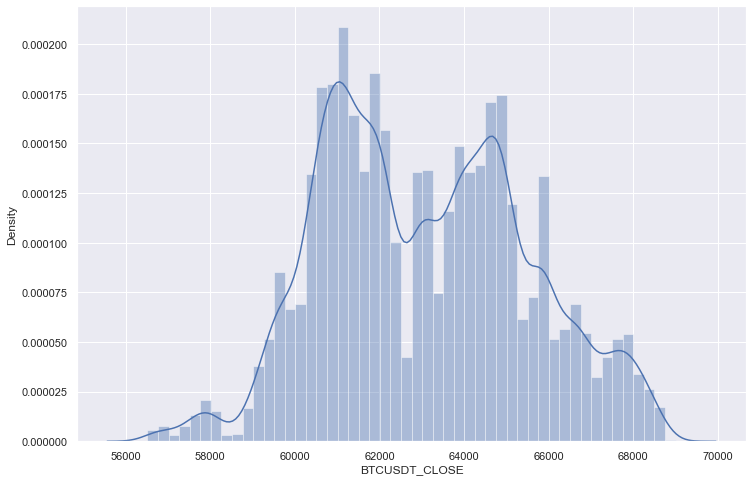

In [22]:
# Just having a look.

sns.distplot(df_pivot['BTCUSDT_CLOSE'])
plt.show()

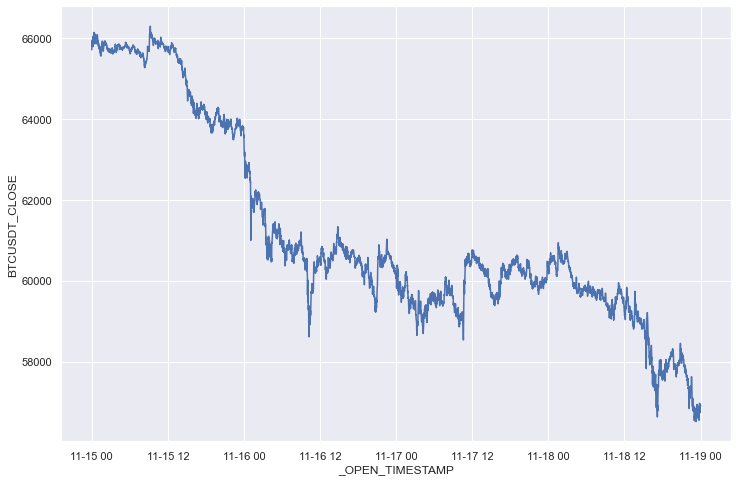

In [23]:
# Just having a look.

sns.lineplot(x="_OPEN_TIMESTAMP", y="BTCUSDT_CLOSE", data=df_pivot.query('_OPEN_TIMESTAMP >= "2021-11-15"'))
plt.show()

In [24]:
# Filtering pivoted day to most recent 3 days.

df_pivot_filtered = df_pivot.iloc[-4320:]
df_pivot_filtered.shape

(4320, 85)

In [25]:
# Just checking it out.

df_pivot_filtered.tail()

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
25915,2021-11-18 23:55:00,99.08,0.9736,56845.0,0.4293,38.88,3.00,3988.0,1.84,0.2311,...,3490.81,20602.8,188.2945,168791.0,2590727.0,10522.32,26043.0,285141.0,63631.9,787.87
25916,2021-11-18 23:56:00,99.39,0.9744,56866.0,0.4296,38.97,3.02,3992.0,1.84,0.2303,...,3445.58,77247.0,160.4218,65825.0,822688.0,4037.30,15178.0,148136.0,86954.9,783.77
25917,2021-11-18 23:57:00,99.70,0.9761,56878.0,0.4300,39.00,3.02,3994.0,1.85,0.2315,...,10809.06,30169.1,218.0851,132444.0,2050754.0,2254.79,11380.0,222219.0,139101.3,756.34
25918,2021-11-18 23:58:00,100.14,0.9781,56937.0,0.4313,39.06,3.03,4001.0,1.85,0.2321,...,3000.74,44447.8,266.5702,42566.0,745368.0,3626.33,37763.0,138243.0,26230.5,524.29
25919,2021-11-18 23:59:00,100.63,0.9781,56892.0,0.4298,39.03,3.04,3997.0,1.85,0.2288,...,8347.22,54510.0,578.3948,58710.0,2033984.0,11614.19,63288.0,117158.0,45452.6,2501.90


## Pandas Profiling

In [26]:
# # Create an amazing report describing the dataframe. Find this file by expand the left pane and clicking on the folder icon. This is perfect for sharing!
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df_pivot_filtered)
# profile.to_file(output_file='PandasProfiling_df_pivot_filtered.html')

In [27]:
df_pivot_filtered.tail()

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
25915,2021-11-18 23:55:00,99.08,0.9736,56845.0,0.4293,38.88,3.00,3988.0,1.84,0.2311,...,3490.81,20602.8,188.2945,168791.0,2590727.0,10522.32,26043.0,285141.0,63631.9,787.87
25916,2021-11-18 23:56:00,99.39,0.9744,56866.0,0.4296,38.97,3.02,3992.0,1.84,0.2303,...,3445.58,77247.0,160.4218,65825.0,822688.0,4037.30,15178.0,148136.0,86954.9,783.77
25917,2021-11-18 23:57:00,99.70,0.9761,56878.0,0.4300,39.00,3.02,3994.0,1.85,0.2315,...,10809.06,30169.1,218.0851,132444.0,2050754.0,2254.79,11380.0,222219.0,139101.3,756.34
25918,2021-11-18 23:58:00,100.14,0.9781,56937.0,0.4313,39.06,3.03,4001.0,1.85,0.2321,...,3000.74,44447.8,266.5702,42566.0,745368.0,3626.33,37763.0,138243.0,26230.5,524.29
25919,2021-11-18 23:59:00,100.63,0.9781,56892.0,0.4298,39.03,3.04,3997.0,1.85,0.2288,...,8347.22,54510.0,578.3948,58710.0,2033984.0,11614.19,63288.0,117158.0,45452.6,2501.90


## Analyzing Pearson's Correlation

In [28]:
# Dataframe of only close prices for analysis

df_close = df_pivot_filtered.set_index('_OPEN_TIMESTAMP').loc[:,df_pivot_filtered.set_index('_OPEN_TIMESTAMP').columns.str.endswith('CLOSE')]
df_close.columns

Index(['AVAXUSDT_CLOSE', 'BATUSDT_CLOSE', 'BTCUSDT_CLOSE', 'CHZUSDT_CLOSE',
       'DOTUSDT_CLOSE', 'ENJUSDT_CLOSE', 'ETHUSDT_CLOSE', 'FTMUSDT_CLOSE',
       'GALAUSDT_CLOSE', 'LINKUSDT_CLOSE', 'LRCUSDT_CLOSE', 'MANAUSDT_CLOSE',
       'MATICUSDT_CLOSE', 'SOLUSDT_CLOSE'],
      dtype='object')

In [29]:
# Checking for nulls. None present.

df_close.isnull().sum()

AVAXUSDT_CLOSE     0
BATUSDT_CLOSE      0
BTCUSDT_CLOSE      0
CHZUSDT_CLOSE      0
DOTUSDT_CLOSE      0
ENJUSDT_CLOSE      0
ETHUSDT_CLOSE      0
FTMUSDT_CLOSE      0
GALAUSDT_CLOSE     0
LINKUSDT_CLOSE     0
LRCUSDT_CLOSE      0
MANAUSDT_CLOSE     0
MATICUSDT_CLOSE    0
SOLUSDT_CLOSE      0
dtype: int64

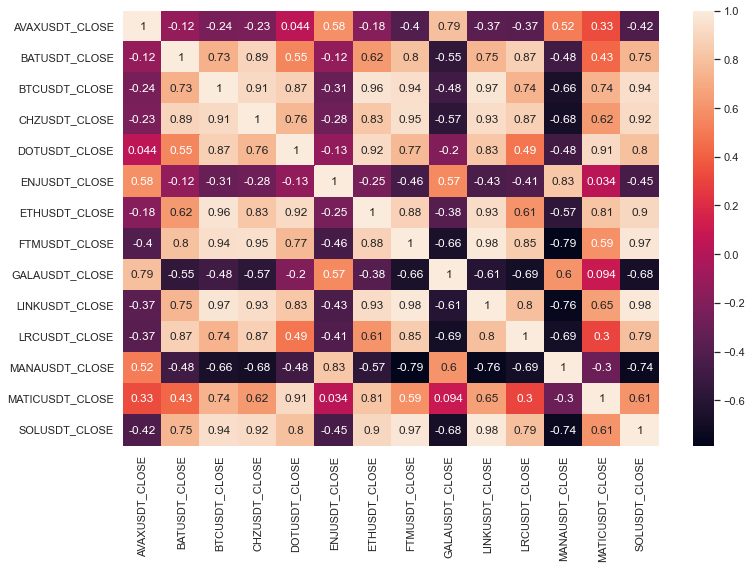

In [30]:
# Correlationon filtered data.

corrMatrix = df_close.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [31]:
# Convert correlation matrix to 1-D Series and sort

sorted_corrmat = pd.DataFrame(corrMatrix.unstack(),columns= {'Correlation'})
print(sorted_corrmat.shape)
sorted_corrmat.head()

(196, 1)


Correlation
AVAXUSDT_CLOSE AVAXUSDT_CLOSE     1.000000
               BATUSDT_CLOSE     -0.119873
               BTCUSDT_CLOSE     -0.239913
               CHZUSDT_CLOSE     -0.231108
               DOTUSDT_CLOSE      0.043790

In [32]:
# Checking for nulls. None present.

sorted_corrmat.isnull().sum()

Correlation    0
dtype: int64

---
**Formatter**

In [33]:
# Filter out 1's.
# Duplicate correlations present
sorted_corrmat = sorted_corrmat[sorted_corrmat.Correlation < 1].sort_values('Correlation', ascending=False)
sorted_corrmat.drop_duplicates(keep='first', inplace=True)
print(sorted_corrmat.shape)
sorted_corrmat.head(10)

(91, 1)


Correlation
FTMUSDT_CLOSE  LINKUSDT_CLOSE     0.980891
SOLUSDT_CLOSE  LINKUSDT_CLOSE     0.979190
FTMUSDT_CLOSE  SOLUSDT_CLOSE      0.973788
BTCUSDT_CLOSE  LINKUSDT_CLOSE     0.968758
               ETHUSDT_CLOSE      0.961841
CHZUSDT_CLOSE  FTMUSDT_CLOSE      0.949467
BTCUSDT_CLOSE  SOLUSDT_CLOSE      0.937248
               FTMUSDT_CLOSE      0.937218
CHZUSDT_CLOSE  LINKUSDT_CLOSE     0.932973
LINKUSDT_CLOSE ETHUSDT_CLOSE      0.926161

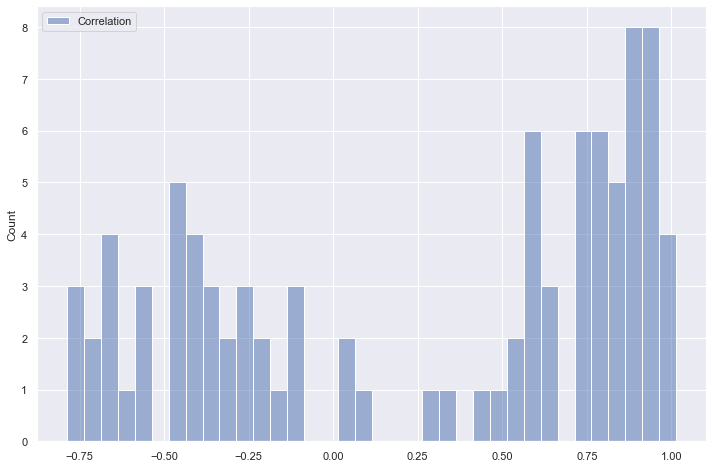

In [34]:
# Having a look at the distribution of the correlations.

sns.histplot(sorted_corrmat, binwidth=0.05)
plt.show()

In [35]:
# Top positively correlated coins.

sorted_corrmat_high = pd.DataFrame(sorted_corrmat[sorted_corrmat.Correlation > 0.90].sort_values('Correlation', ascending=False))
sorted_corrmat_high.reset_index(inplace=True)
print(sorted_corrmat_high.shape)
print(sorted_corrmat_high)

(15, 3)
           level_0          level_1  Correlation
0    FTMUSDT_CLOSE   LINKUSDT_CLOSE     0.980891
1    SOLUSDT_CLOSE   LINKUSDT_CLOSE     0.979190
2    FTMUSDT_CLOSE    SOLUSDT_CLOSE     0.973788
3    BTCUSDT_CLOSE   LINKUSDT_CLOSE     0.968758
4    BTCUSDT_CLOSE    ETHUSDT_CLOSE     0.961841
5    CHZUSDT_CLOSE    FTMUSDT_CLOSE     0.949467
6    BTCUSDT_CLOSE    SOLUSDT_CLOSE     0.937248
7    BTCUSDT_CLOSE    FTMUSDT_CLOSE     0.937218
8    CHZUSDT_CLOSE   LINKUSDT_CLOSE     0.932973
9   LINKUSDT_CLOSE    ETHUSDT_CLOSE     0.926161
10   SOLUSDT_CLOSE    CHZUSDT_CLOSE     0.922969
11   ETHUSDT_CLOSE    DOTUSDT_CLOSE     0.918805
12   DOTUSDT_CLOSE  MATICUSDT_CLOSE     0.913340
13   BTCUSDT_CLOSE    CHZUSDT_CLOSE     0.912415
14   ETHUSDT_CLOSE    SOLUSDT_CLOSE     0.904877


In [36]:
# Assembling high correlation coins

df_high0 = pd.DataFrame(df_close[sorted_corrmat_high['level_0'].unique()])
df_high0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4320 entries, 2021-11-16 00:00:00 to 2021-11-18 23:59:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FTMUSDT_CLOSE   4320 non-null   float64
 1   SOLUSDT_CLOSE   4320 non-null   float64
 2   BTCUSDT_CLOSE   4320 non-null   float64
 3   CHZUSDT_CLOSE   4320 non-null   float64
 4   LINKUSDT_CLOSE  4320 non-null   float64
 5   ETHUSDT_CLOSE   4320 non-null   float64
 6   DOTUSDT_CLOSE   4320 non-null   float64
dtypes: float64(7)
memory usage: 270.0 KB


In [37]:
# Assembling high correlation coins

df_high1 = pd.DataFrame(df_close[sorted_corrmat_high['level_1'].unique()])
df_high1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4320 entries, 2021-11-16 00:00:00 to 2021-11-18 23:59:00
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LINKUSDT_CLOSE   4320 non-null   float64
 1   SOLUSDT_CLOSE    4320 non-null   float64
 2   ETHUSDT_CLOSE    4320 non-null   float64
 3   FTMUSDT_CLOSE    4320 non-null   float64
 4   CHZUSDT_CLOSE    4320 non-null   float64
 5   DOTUSDT_CLOSE    4320 non-null   float64
 6   MATICUSDT_CLOSE  4320 non-null   float64
dtypes: float64(7)
memory usage: 270.0 KB


In [38]:
# Assembling high correlation coins

df_high = pd.concat([df_high0, df_high1], axis=1).reset_index(drop=True).drop_duplicates()
df_high = df_high.loc[:,~df_high.columns.duplicated()]
print(df_high.shape)
df_high.head()

(4320, 8)


,FTMUSDT_CLOSE,SOLUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,LINKUSDT_CLOSE,ETHUSDT_CLOSE,DOTUSDT_CLOSE,MATICUSDT_CLOSE
0,2.46,237.0,63432.0,0.5318,32.00,4554.0,44.67,1.69
1,2.46,237.0,63340.0,0.5306,31.90,4546.0,44.59,1.68
2,2.46,237.0,63228.0,0.5285,31.72,4541.0,44.48,1.68
3,2.45,237.0,63148.0,0.5273,31.64,4534.0,44.34,1.67
4,2.45,236.0,63091.0,0.5251,31.53,4530.0,44.30,1.67


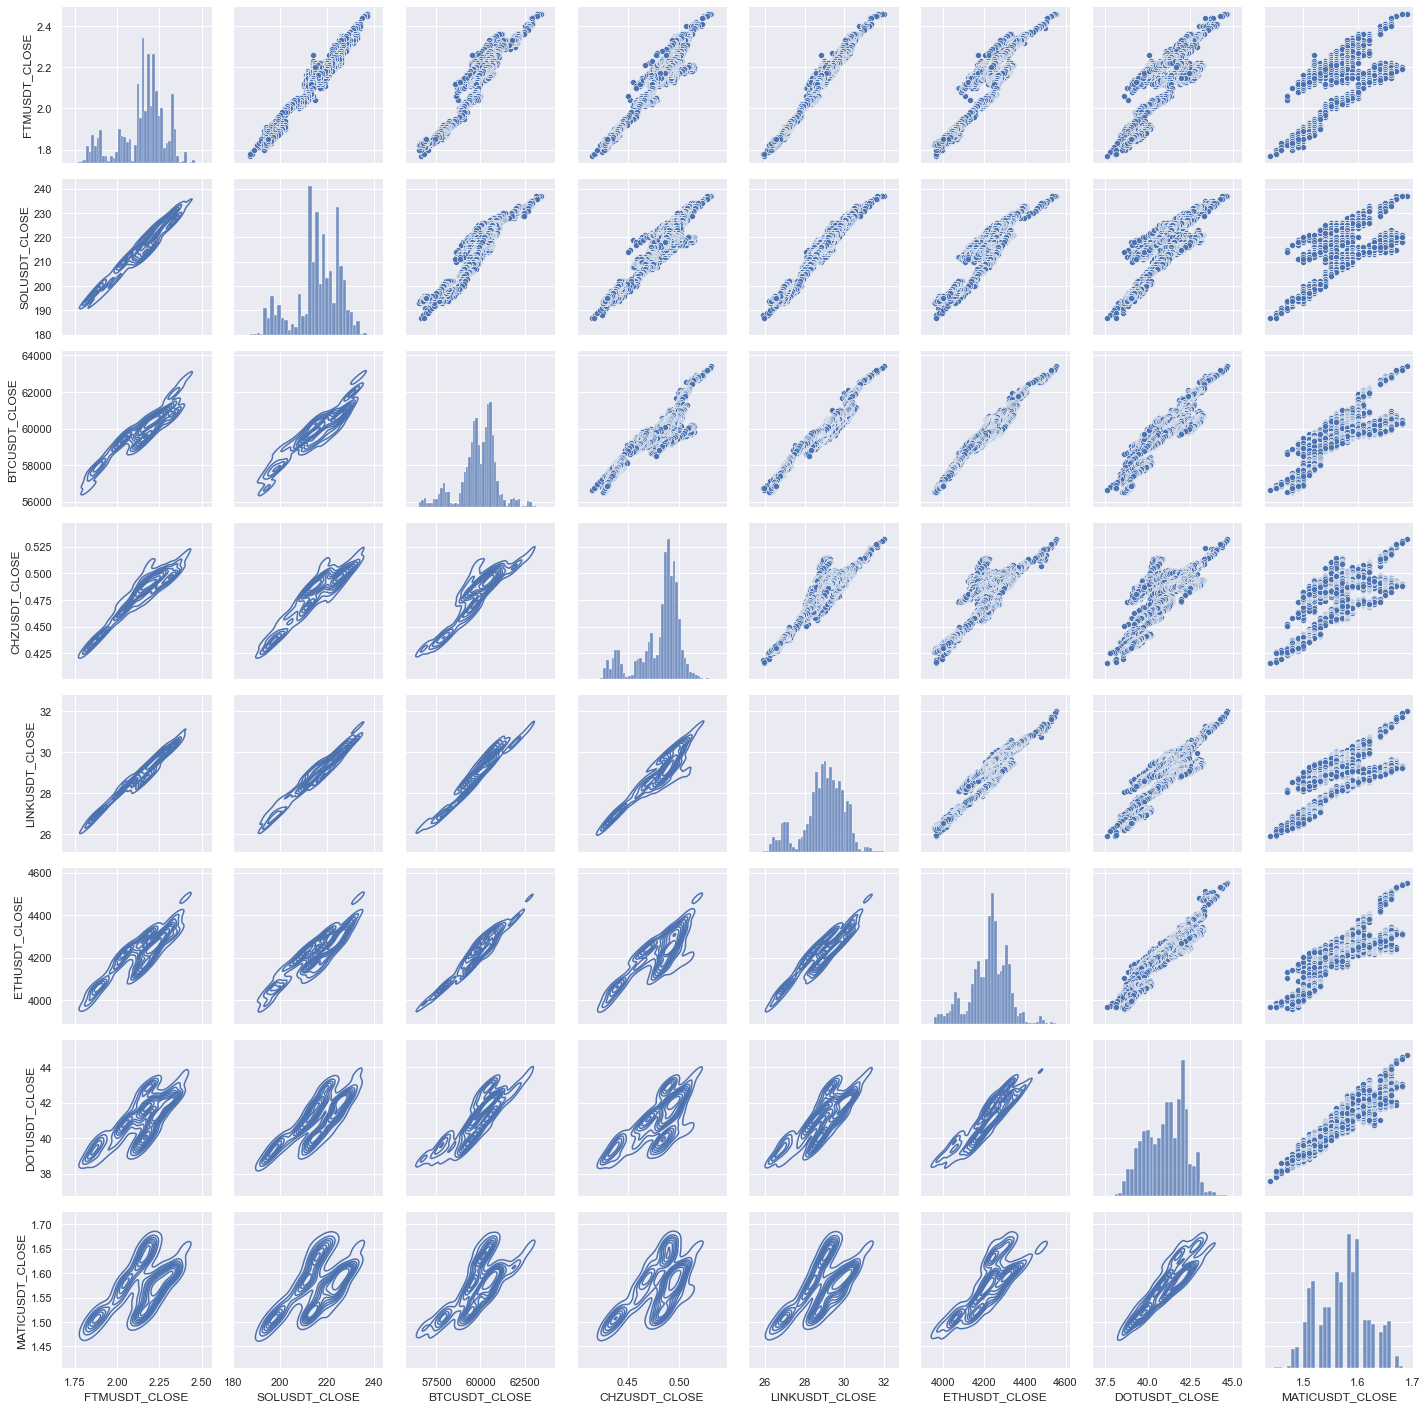

In [39]:
# Having a look at highly correlated coins

g = sns.PairGrid(df_high)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)
plt.show()

In [40]:
# Top negatively correlated coins.

sorted_corrmat_low = pd.DataFrame(sorted_corrmat[sorted_corrmat.Correlation < -0.65].sort_values('Correlation', ascending=True))
sorted_corrmat_low.reset_index(inplace=True)
print(sorted_corrmat_low.shape)
print(sorted_corrmat_low)

(9, 3)
          level_0         level_1  Correlation
0  MANAUSDT_CLOSE   FTMUSDT_CLOSE    -0.786267
1  LINKUSDT_CLOSE  MANAUSDT_CLOSE    -0.756814
2  MANAUSDT_CLOSE   SOLUSDT_CLOSE    -0.743023
3  GALAUSDT_CLOSE   LRCUSDT_CLOSE    -0.693271
4   LRCUSDT_CLOSE  MANAUSDT_CLOSE    -0.690210
5   CHZUSDT_CLOSE  MANAUSDT_CLOSE    -0.681865
6  GALAUSDT_CLOSE   SOLUSDT_CLOSE    -0.679556
7   BTCUSDT_CLOSE  MANAUSDT_CLOSE    -0.660695
8  GALAUSDT_CLOSE   FTMUSDT_CLOSE    -0.657398


In [41]:
# Assembling low correlation coins

df_low0 = pd.DataFrame(df_close[sorted_corrmat_low['level_0'].unique()])
df_low0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4320 entries, 2021-11-16 00:00:00 to 2021-11-18 23:59:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MANAUSDT_CLOSE  4320 non-null   float64
 1   LINKUSDT_CLOSE  4320 non-null   float64
 2   GALAUSDT_CLOSE  4320 non-null   float64
 3   LRCUSDT_CLOSE   4320 non-null   float64
 4   CHZUSDT_CLOSE   4320 non-null   float64
 5   BTCUSDT_CLOSE   4320 non-null   float64
dtypes: float64(6)
memory usage: 236.2 KB


In [42]:
# Assembling low correlation coins

df_low1 = pd.DataFrame(df_close[sorted_corrmat_low['level_1'].unique()])
df_low1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4320 entries, 2021-11-16 00:00:00 to 2021-11-18 23:59:00
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FTMUSDT_CLOSE   4320 non-null   float64
 1   MANAUSDT_CLOSE  4320 non-null   float64
 2   SOLUSDT_CLOSE   4320 non-null   float64
 3   LRCUSDT_CLOSE   4320 non-null   float64
dtypes: float64(4)
memory usage: 168.8 KB


In [43]:
# Assembling low correlation coins

df_low = pd.concat([df_low0, df_low1], axis=1).reset_index(drop=True).drop_duplicates()
df_low = df_low.loc[:,~df_low.columns.duplicated()]
print(df_low.shape)
df_low.head()

(4320, 8)


,MANAUSDT_CLOSE,LINKUSDT_CLOSE,GALAUSDT_CLOSE,LRCUSDT_CLOSE,CHZUSDT_CLOSE,BTCUSDT_CLOSE,FTMUSDT_CLOSE,SOLUSDT_CLOSE
0,3.26,32.00,0.1272,2.8962,0.5318,63432.0,2.46,237.0
1,3.27,31.90,0.1291,2.8760,0.5306,63340.0,2.46,237.0
2,3.22,31.72,0.1291,2.8788,0.5285,63228.0,2.46,237.0
3,3.24,31.64,0.1286,2.8813,0.5273,63148.0,2.45,237.0
4,3.23,31.53,0.1271,2.8761,0.5251,63091.0,2.45,236.0


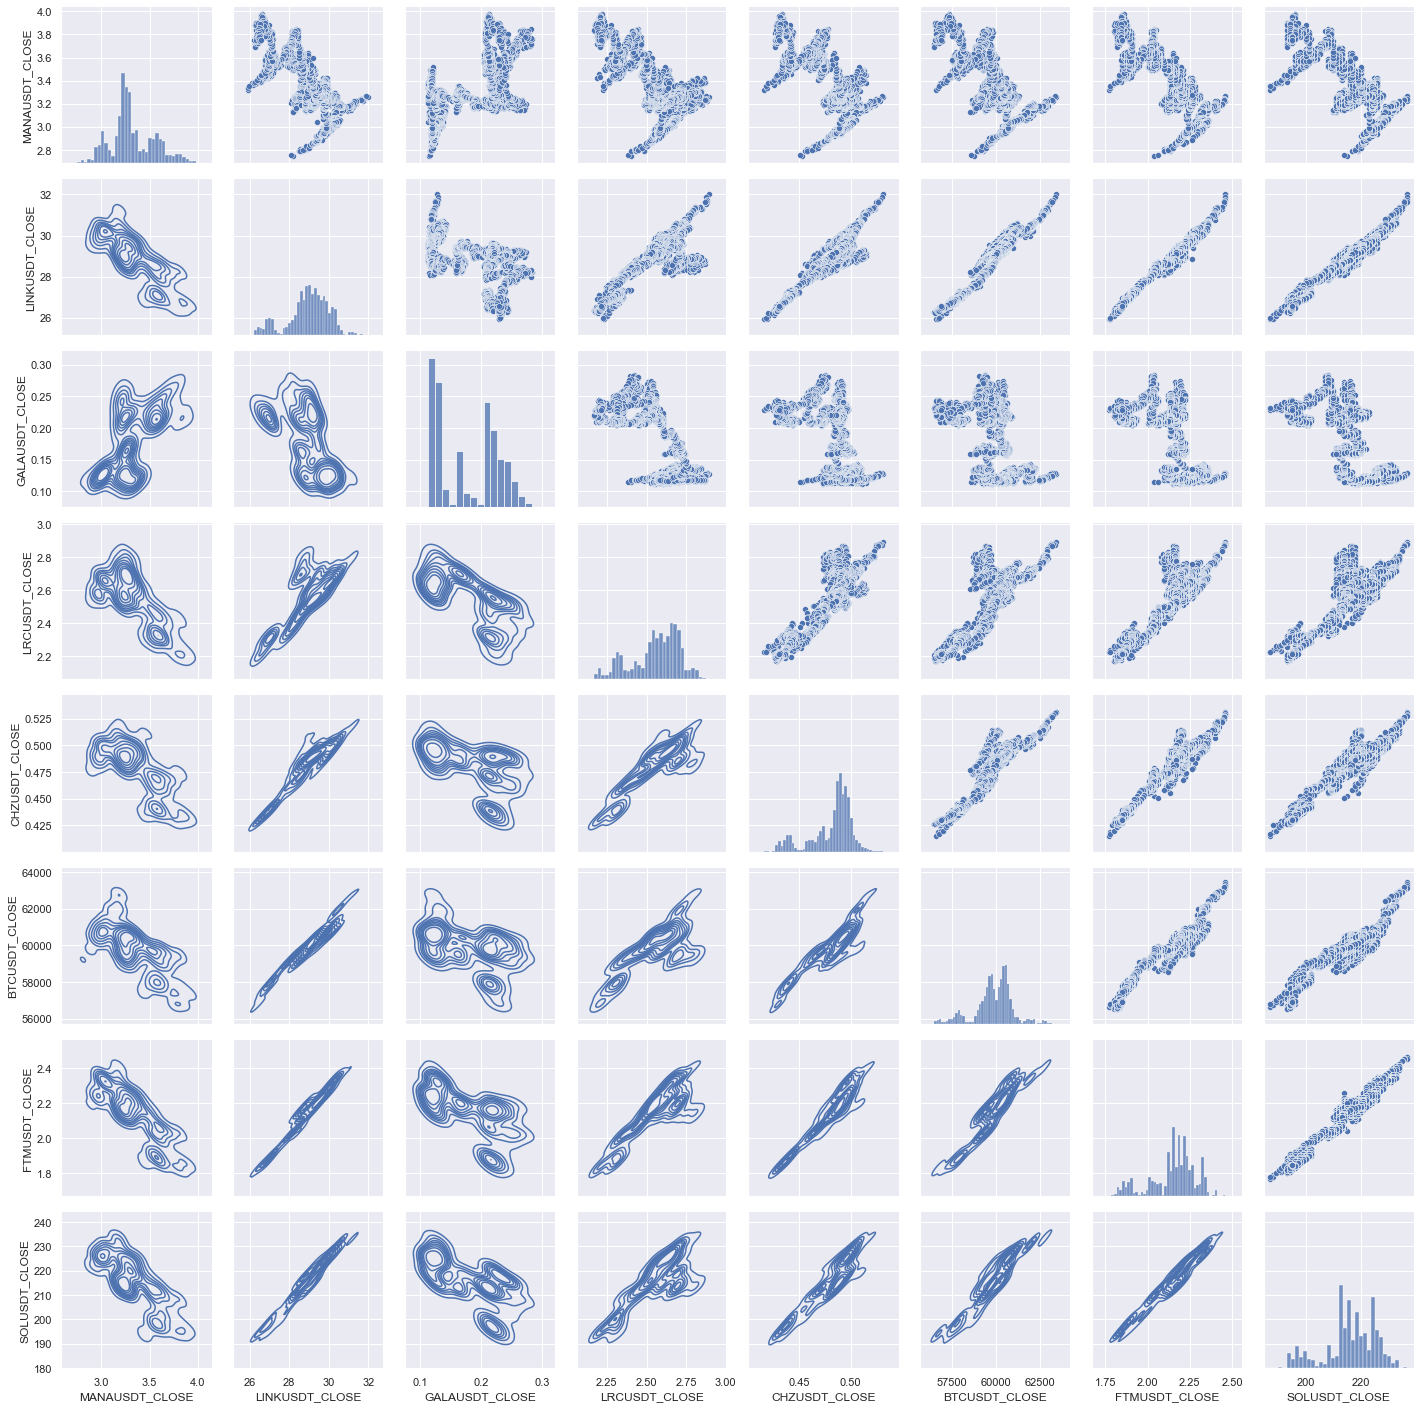

In [44]:
# Having a look at low correlated coins

g = sns.PairGrid(df_low)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)
plt.show()

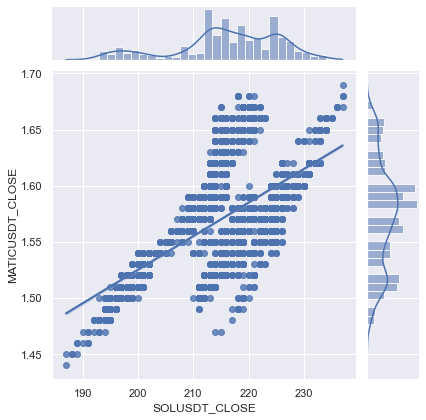

In [45]:
# Looking at correlation and distribution

plt.show(sns.jointplot(data=df_close, x="SOLUSDT_CLOSE", y="MATICUSDT_CLOSE", kind="reg"))

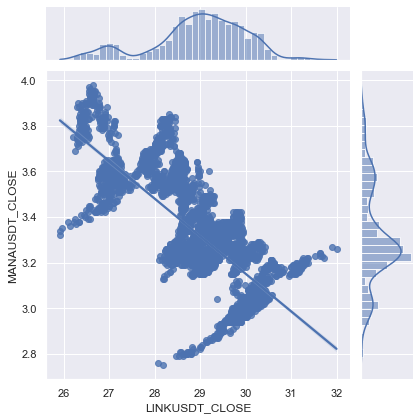

In [46]:
# Looking at correlation and distribution

plt.show(sns.jointplot(data=df_close, x="LINKUSDT_CLOSE", y="MANAUSDT_CLOSE", kind="reg"))

## Signal Processing

https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

https://jinhyuncheong.com/jekyll/update/2017/12/10/Timeseries_synchrony_tutorial_and_simulations.html

In [47]:
# Filteirng dataframe down to the most recent half day

df_close = df_close[int(-(1440/2)):]
df_close.shape

(720, 14)

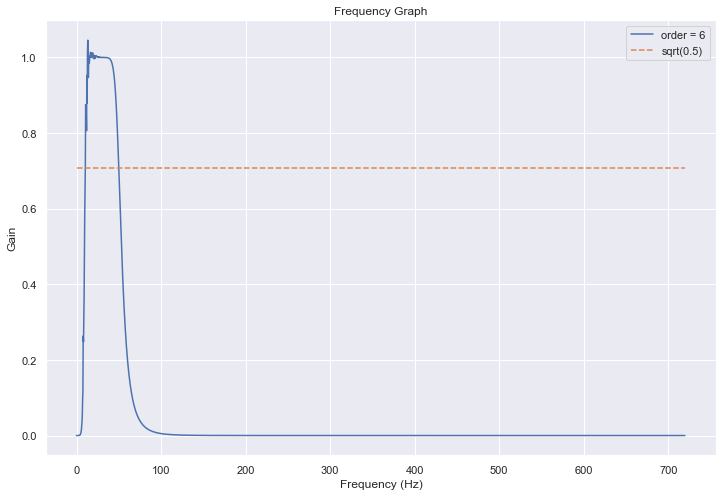

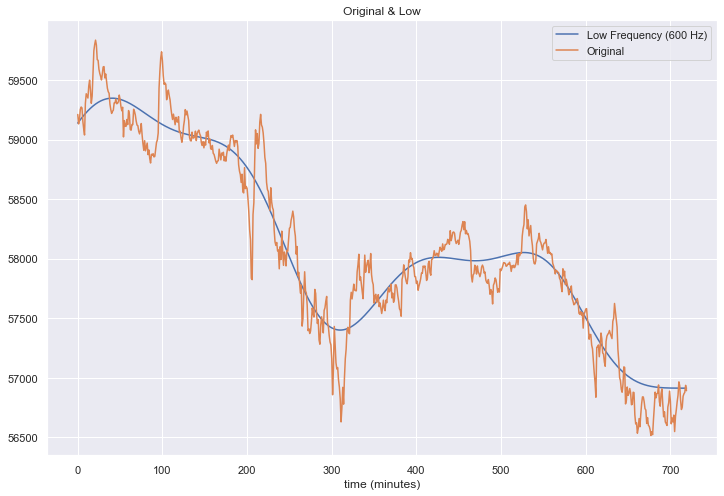

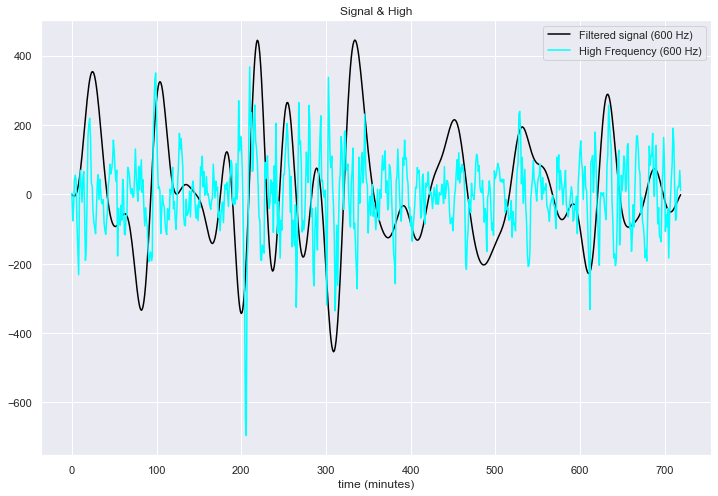

In [48]:
from scipy.signal import butter, lfilter, filtfilt

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

#def plot_sp_coin(coin):

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1440 # The sampling frequency of the digital system. Nyquist is biggest observable frequency (half of fs)
lowcut = 10 # Fl in screenshot below
highcut = 50 # Fh in screenshot below

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [6]: #add more numbers to the list to determine cuts
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)

    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
plt.title("Frequency Graph")

# Filter a noisy signal.
T = 0.05
nsamples = int(T * fs)
t = np.linspace(0, T, nsamples, endpoint=False)
a = 0.02
f0 = 600.0 # This determines the Hz...see legend in second chart

plt.figure(2)

# Plot the signal
# y = butter_bandpass_filter(df_close[coin], lowcut, highcut, fs, order=6)
# y2 = butter_highpass_filter(df_close[coin], highcut, fs, order=6)
# y3 = butter_lowpass_filter(df_close[coin], lowcut, fs, order=6)

y = butter_bandpass_filter(df_close['BTCUSDT_CLOSE'], lowcut, highcut, fs, order=6)
y2 = butter_highpass_filter(df_close['BTCUSDT_CLOSE'], highcut, fs, order=6)
y3 = butter_lowpass_filter(df_close['BTCUSDT_CLOSE'], lowcut, fs, order=6)

plt.plot(range(df_close.shape[0]), y3, label='Low Frequency (%g Hz)' % f0)
plt.plot(range(df_close.shape[0]),df_close['BTCUSDT_CLOSE'], label='Original')
plt.xlabel('time (minutes)')
plt.legend(loc='best')
plt.title("Original & Low")

plt.figure(3)

plt.plot(range(df_close.shape[0]), y, c='black', label='Filtered signal (%g Hz)' % f0)
plt.plot(range(df_close.shape[0]), y2, c='cyan', label='High Frequency (%g Hz)' % f0)
plt.xlabel('time (minutes)')
plt.legend(loc='best')
#plt.hlines([-a, a], 0, (1440/2), linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.title("Signal & High")
    
plt.legend(loc='best')
plt.show()

---
**Formatter**

In [49]:
from scipy.signal import butter, lfilter, filtfilt

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# This is a function that Ian will use to compile analyses into the master table.
# The function has 2 arguments. One is the coin and the other is the referenced dataframe.
# Coin is a list of the headers from the df_close table, which are the coin names. Alternatively could be a dict etc.
def plot_sp_coin(coin, df_close):

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 1440 # The sampling frequency of the digital system. Nyquist is biggest observable frequency (half of fs)
    lowcut = 10 # Fl in screenshot below
    highcut = 50 # Fh in screenshot below

    y = butter_bandpass_filter(df_close[coin], lowcut, highcut, fs, order=6)
    y2 = butter_highpass_filter(df_close[coin], highcut, fs, order=6)
    y3 = butter_lowpass_filter(df_close[coin], lowcut, fs, order=6)
    return pd.DataFrame({"middle":y, "high":y2, "low":y3}, index=df_close.index)    
   

In [50]:
for coin in df_close:
    df_ian = plot_sp_coin(coin, df_close)
    display(df_ian.head())


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.039549,-0.009120,102.196980
2021-11-18 12:01:00,0.016182,-0.019081,102.229082
2021-11-18 12:02:00,0.071086,0.091435,102.260893
2021-11-18 12:03:00,0.124716,0.212780,102.292385
2021-11-18 12:04:00,0.176646,0.165311,102.323529


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.001082,0.000082,1.029634
2021-11-18 12:01:00,-0.000470,-0.002327,1.029835
2021-11-18 12:02:00,0.000151,-0.001744,1.030031
2021-11-18 12:03:00,0.000778,-0.000569,1.030220
2021-11-18 12:04:00,0.001411,0.001200,1.030403


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-1.093369,2.924117,59138.171735
2021-11-18 12:01:00,-3.479606,-76.499451,59147.779851
2021-11-18 12:02:00,-5.075582,-40.998335,59157.225162
2021-11-18 12:03:00,-5.258010,39.789499,59166.500330
2021-11-18 12:04:00,-3.467462,55.304846,59175.598225


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.000687,0.000021,0.469048
2021-11-18 12:01:00,-0.000111,-0.000955,0.469200
2021-11-18 12:02:00,0.000464,-0.001426,0.469348
2021-11-18 12:03:00,0.001028,0.001014,0.469493
2021-11-18 12:04:00,0.001576,0.002073,0.469634


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.021144,0.001653,40.246064
2021-11-18 12:01:00,-0.026262,-0.106036,40.260702
2021-11-18 12:02:00,-0.030464,-0.034484,40.275192
2021-11-18 12:03:00,-0.033079,0.015654,40.289520
2021-11-18 12:04:00,-0.033505,0.013787,40.303676


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.008968,0.000770,3.144762
2021-11-18 12:01:00,-0.004008,-0.015220,3.146108
2021-11-18 12:02:00,0.000969,-0.031178,3.147440
2021-11-18 12:03:00,0.005861,-0.017010,3.148759
2021-11-18 12:04:00,0.010566,-0.002624,3.150061


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-1.699080,0.326364,4183.329228
2021-11-18 12:01:00,-2.149810,-11.381528,4183.918988
2021-11-18 12:02:00,-2.526607,-7.180760,4184.497073
2021-11-18 12:03:00,-2.776533,-1.127335,4185.062972
2021-11-18 12:04:00,-2.852409,-2.270205,4185.616188


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.000288,0.000128,2.018307
2021-11-18 12:01:00,0.000469,-0.000873,2.018674
2021-11-18 12:02:00,0.001232,-0.001882,2.019037
2021-11-18 12:03:00,0.001997,0.007104,2.019396
2021-11-18 12:04:00,0.002757,0.006092,2.019751


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.001066,0.000257,0.273403
2021-11-18 12:01:00,0.000380,-0.004160,0.273299
2021-11-18 12:02:00,0.001805,-0.000954,0.273192
2021-11-18 12:03:00,0.003171,-0.001888,0.273084
2021-11-18 12:04:00,0.004443,0.003974,0.272972


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.013959,0.001932,28.079991
2021-11-18 12:01:00,-0.013420,-0.060338,28.085511
2021-11-18 12:02:00,-0.012361,-0.023217,28.090931
2021-11-18 12:03:00,-0.010495,0.032981,28.096249
2021-11-18 12:04:00,-0.007575,0.027988,28.101458


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,0.000859,0.000001,2.420864
2021-11-18 12:01:00,0.000607,-0.027484,2.420775
2021-11-18 12:02:00,0.000397,-0.016829,2.420671
2021-11-18 12:03:00,0.000266,-0.005277,2.420552
2021-11-18 12:04:00,0.000245,0.002537,2.420417


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.008830,0.000215,3.697407
2021-11-18 12:01:00,-0.003344,-0.018267,3.700649
2021-11-18 12:02:00,0.002179,-0.016741,3.703859
2021-11-18 12:03:00,0.007698,-0.025176,3.707036
2021-11-18 12:04:00,0.013169,-0.023537,3.710175


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.001041,0.000206,1.558807
2021-11-18 12:01:00,-0.000603,-0.000425,1.559172
2021-11-18 12:02:00,-0.000145,-0.001078,1.559531
2021-11-18 12:03:00,0.000340,0.008238,1.559884
2021-11-18 12:04:00,0.000860,0.007520,1.560230


,middle,high,low
_OPEN_TIMESTAMP,,,
2021-11-18 12:00:00,-0.101314,0.011610,208.002592
2021-11-18 12:01:00,-0.201400,-0.899653,208.017615
2021-11-18 12:02:00,-0.297552,-0.814630,208.032144
2021-11-18 12:03:00,-0.386531,0.263598,208.046160
2021-11-18 12:04:00,-0.465353,0.332178,208.059639


In [51]:
# Constructing a dataframe to double check the math adds up.

df_bbf = pd.DataFrame({"Middle":y, "High":y2, "Low":y3, "Price":df_close['BTCUSDT_CLOSE'].values})
df_bbf['Total'] = (y+y2+y3)
df_bbf['Var_Num'] = (df_close['BTCUSDT_CLOSE'].values - (y+y2+y3) )
df_bbf['Var_Pct'] = (df_close['BTCUSDT_CLOSE'].values / (y+y2+y3) -1 )
df_bbf.tail(25)

,Middle,High,Low,Price,Total,Var_Num,Var_Pct
695,35.147485,-126.279547,56915.266949,56616.0,56824.134886,-208.134886,-0.003663
696,24.989489,-136.749320,56914.989097,56600.0,56803.229267,-203.229267,-0.003578
697,14.498826,23.342227,56914.740422,56755.0,56952.581475,-197.581475,-0.003469
698,3.991048,63.703866,56914.518582,56791.0,56982.213495,-191.213495,-0.003356
699,-6.226861,164.077888,56914.321354,56888.0,57072.172381,-184.172381,-0.003227
...,...,...,...,...,...,...,...
715,-21.515727,12.979609,56913.132892,56845.0,56904.596774,-59.596774,-0.001047
716,-15.999087,22.117671,56913.120163,56866.0,56919.238747,-53.238747,-0.000935
717,-10.678524,22.082791,56913.110000,56878.0,56924.514268,-46.514268,-0.000817
718,-5.693177,68.809804,56913.101973,56937.0,56976.218600,-39.218600,-0.000688


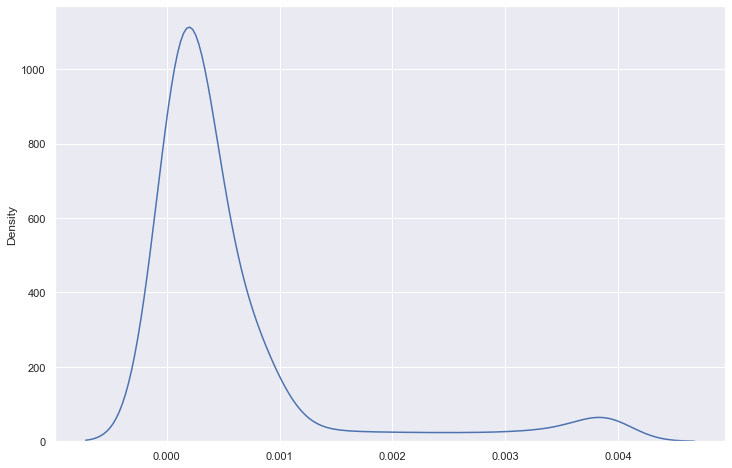

In [52]:
# Nearly all of the price is low frequency.

sns.kdeplot(((df_bbf[["Middle", "High", "Low"]].sum(axis=1) - df_bbf["Price"]).abs()/df_bbf["Price"]))#'.hist()
plt.show()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

Design an Nth-order digital or analog Butterworth filter and return the filter coefficients.

For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).

For lowpass and highpass filters, Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 sequence.

For example, the ID list for item b consists of the following (SID, EID) pairs: {(1, 2), (2, 3), (3, 2), (3, 5), (4, 5)}, 
where the entry (1, 2) means that b occurs in sequence 1, event 2, and so on. Items a and b are frequent. They can
be joined to form the length-2 sequence, (a,b)

A band-pass filter or bandpass filter (BPF) is a device that passes frequencies within a certain range and rejects 

For digital filters, Wn are in the same units as fs. By default, fs is 2 half-cycles/sample, so these are normalized from 0 to 1, where 1 is the Nyquist frequency. (Wn is thus in half-cycles / sample.)

btype{‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, optional
The type of filter. Default is ‘lowpass

fsfloat, optional ..... The sampling frequency of the digital system.

https://kevin-kotze.gitlab.io/tsm/ts-6-note/
- Most economic time series exhibit behaviour that is repeated over time. Time series variables is that they may be decomposed into different periodic variations.
- For example, we may wish to extract the cyclical component of the time series, which may be regarded as the part that exhibits higher periodic variation than the trend.
- able to conduct an investigation into the behaviour of the business cycle
- When seeking to decompose a time series into different periodic variations, we could imagine that the process is responding to various driving frequencies that are produced from linear combinations of sine and cosine functions, where each of these sine and cosine functions would represent a different frequency or amplitude. Expressed in these terms, the application of frequency domain techniques may be regarded as a regression of periodic sine and cosines on the respective values of the time series.3

https://en.wikipedia.org/wiki/Frequency
- Frequency is the number of occurrences of a repeating event per unit of time.
- Frequency is measured in hertz (Hz) which is equal to one event per second.
- The period is the duration of time of one cycle in a repeating event, so the period is the reciprocal of the frequency.[2]
- For example, if a heart beats at a frequency of 120 times a minute (2 hertz), its period, T—the time interval between beats—is half a second (60 seconds divided by 120 beats).
- Angular frequency is commonly measured in radians per second (rad/s) but, for discrete-time signals, can also be expressed as radians per sampling interval, which is a dimensionless quantity. Angular frequency (in rad/s) is larger than ordinary frequency (in Hz) by a factor of 2π.

The Butterworth filter is a type of signal processing filter designed to have a frequency response that is as flat as possible in the passband.
- Frequency response : It is a measure of magnitude and phase of the output as a function of frequency, in comparison to the input.
	- For a linear system, doubling the amplitude of the input will double the amplitude of the output, and summing two inputs produces an output that is the sum of the two corresponding outputs to the individual inputs.
	- In addition, if the system is time-invariant (so LTI), then the frequency response also will not vary with time, and injecting a sine wave into the system at a given frequency will make the system respond at that same frequency with a certain magnitude and a certain phase angle relative to the input. Thus for LTI systems, the frequency response can be seen as applying the system's transfer function to a purely imaginary number argument representing the frequency of the sinusoidal excitation.[1]
	- Estimating the frequency response for a physical system generally involves exciting the system with an input signal, measuring both input and output time histories, and comparing the two through a process such as the Fast Fourier Transform (FFT).
	- The frequency response is characterized by the magnitude of the system's response, typically measured in decibels (dB) or as a decimal, and the phase, measured in radians or degrees, versus frequency in radians/sec or Hertz (Hz).

---
**Formatter**

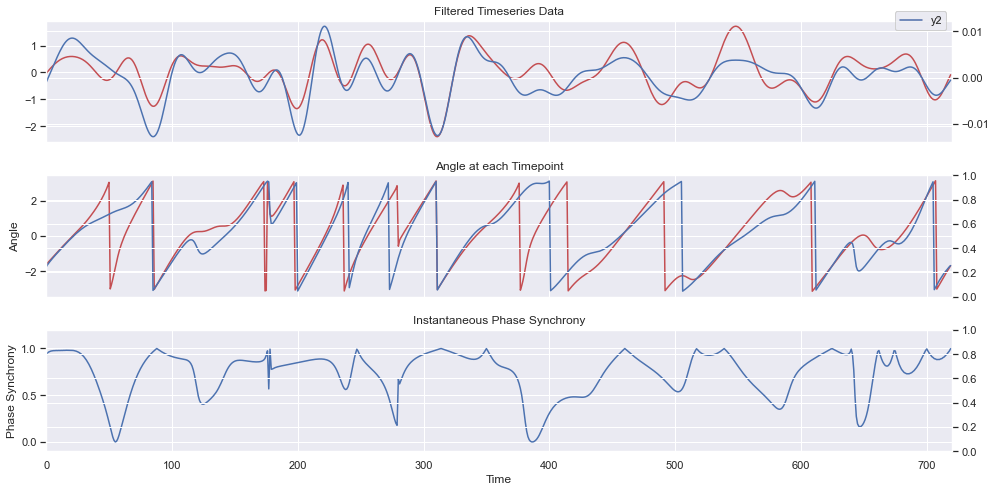

In [87]:
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

#def plot_syn_coin(coin1, coin2):
fs = 1440 # The sampling frequency of the digital system. Nyquist is biggest observable frequency (half of fs)
lowcut = 10 # Fl in screenshot below
highcut = 50 # Fh in screenshot below
order = 6
d1 = df_close['AVAXUSDT_CLOSE'].interpolate().values
d2 = df_close['BATUSDT_CLOSE'].interpolate().values
y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
N = len(al1)

# Plot results
f, ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
ax2 = [a.twinx() for a in ax]

ax[0].plot(y1,color='r',label='y1')
ax2[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax2[0].legend(bbox_to_anchor=(0, 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')

ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)

ax[2].plot(phase_synchrony)
ax[2].set(ylim=[-0.1,1.2],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show() 

In [110]:
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def plot_syn_coin(coin1, coin2, df_close):
    fs = 1440 # The sampling frequency of the digital system. Nyquist is biggest observable frequency (half of fs)
    lowcut = 10 # Fl in screenshot below
    highcut = 50 # Fh in screenshot below
    order = 6
    d1 = df_close[coin1].interpolate().values
    d2 = df_close[coin2].interpolate().values
    y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

    al1 = np.angle(hilbert(y1),deg=False)
    al2 = np.angle(hilbert(y2),deg=False)
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    N = len(al1)
    
    return pd.DataFrame({"phase_synchrony":phase_synchrony}, index=df_close.index)

In [ ]:
from itertools import combinations

for combo in combinations(df_close.columns.tolist(), 2):  # 2 for pairs, 3 for triplets, etc
    df_phase_syn = plot_syn_coin(combo[0], combo[1], df_close)
    display(df_phase_syn.tail())

Filtered timeseries : bandfiltered to represent the true signal. Converted to dual axis to better see the time series of each coin's signal

Angle : Spikes at each trough of the timeseries. Once spiked, it bottoms out to reset. This saw tooth pattern represents the covariance of the coins b/t each trough. If the 2 angles overlap, they the 2 coins covary perfectly. If the angels are not aligned, then the coins stray from one another.

Phase Synchrony : Summarizes the 2 angle lines into a single number. PS of 1 is perfectly synchronous. As the 2 time series stray, the angles deviate and PS falls.

In [55]:
# Normalizing prices for DTW.

df_close['AVAXUSDT_CLOSE_Norm'] = (df_close['AVAXUSDT_CLOSE']-df_close['AVAXUSDT_CLOSE'].mean())/df_close['AVAXUSDT_CLOSE'].std()
df_close['BATUSDT_CLOSE_Norm'] = (df_close['BATUSDT_CLOSE']-df_close['BATUSDT_CLOSE'].mean())/df_close['BATUSDT_CLOSE'].std()
df_close['BTCUSDT_CLOSE_Norm'] = (df_close['BTCUSDT_CLOSE']-df_close['BTCUSDT_CLOSE'].mean())/df_close['BTCUSDT_CLOSE'].std()
df_close['CHZUSDT_CLOSE_Norm'] = (df_close['CHZUSDT_CLOSE']-df_close['CHZUSDT_CLOSE'].mean())/df_close['CHZUSDT_CLOSE'].std()
df_close['DOTUSDT_CLOSE_Norm'] = (df_close['DOTUSDT_CLOSE']-df_close['DOTUSDT_CLOSE'].mean())/df_close['DOTUSDT_CLOSE'].std()
df_close['ENJUSDT_CLOSE_Norm'] = (df_close['ENJUSDT_CLOSE']-df_close['ENJUSDT_CLOSE'].mean())/df_close['ENJUSDT_CLOSE'].std()
df_close['FTMUSDT_CLOSE_Norm'] = (df_close['FTMUSDT_CLOSE']-df_close['FTMUSDT_CLOSE'].mean())/df_close['FTMUSDT_CLOSE'].std()
df_close['GALAUSDT_CLOSE_Norm'] = (df_close['GALAUSDT_CLOSE']-df_close['GALAUSDT_CLOSE'].mean())/df_close['GALAUSDT_CLOSE'].std()
df_close['LINKUSDT_CLOSE_Norm'] = (df_close['LINKUSDT_CLOSE']-df_close['LINKUSDT_CLOSE'].mean())/df_close['LINKUSDT_CLOSE'].std()
df_close['LRCUSDT_CLOSE_Norm'] = (df_close['LRCUSDT_CLOSE']-df_close['LRCUSDT_CLOSE'].mean())/df_close['LRCUSDT_CLOSE'].std()
df_close['MANAUSDT_CLOSE_Norm'] = (df_close['MANAUSDT_CLOSE']-df_close['MANAUSDT_CLOSE'].mean())/df_close['MANAUSDT_CLOSE'].std()
df_close['MATICUSDT_CLOSE_Norm'] = (df_close['MATICUSDT_CLOSE']-df_close['MATICUSDT_CLOSE'].mean())/df_close['MATICUSDT_CLOSE'].std()
df_close['SOLUSDT_CLOSE_Norm'] = (df_close['SOLUSDT_CLOSE']-df_close['SOLUSDT_CLOSE'].mean())/df_close['SOLUSDT_CLOSE'].std()
df_close.tail()

,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,LINKUSDT_CLOSE,...,CHZUSDT_CLOSE_Norm,DOTUSDT_CLOSE_Norm,ENJUSDT_CLOSE_Norm,FTMUSDT_CLOSE_Norm,GALAUSDT_CLOSE_Norm,LINKUSDT_CLOSE_Norm,LRCUSDT_CLOSE_Norm,MANAUSDT_CLOSE_Norm,MATICUSDT_CLOSE_Norm,SOLUSDT_CLOSE_Norm
_OPEN_TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2021-11-18 23:55:00,99.08,0.9736,56845.0,0.4293,38.88,3.00,3988.0,1.84,0.2311,26.42,...,-1.123808,-1.031870,-0.137833,-1.046574,0.010480,-1.342725,-1.478300,0.853457,-0.983558,-0.906032
2021-11-18 23:56:00,99.39,0.9744,56866.0,0.4296,38.97,3.02,3992.0,1.84,0.2303,26.46,...,-1.102011,-0.882691,0.059071,-1.046574,-0.030670,-1.273158,-1.445755,0.928040,-0.983558,-0.906032
2021-11-18 23:57:00,99.70,0.9761,56878.0,0.4300,39.00,3.02,3994.0,1.85,0.2315,26.48,...,-1.072949,-0.832964,0.059071,-0.901413,0.031056,-1.238375,-1.390429,0.704291,-0.608075,-0.906032
2021-11-18 23:58:00,100.14,0.9781,56937.0,0.4313,39.06,3.03,4001.0,1.85,0.2321,26.53,...,-0.978498,-0.733512,0.157523,-0.901413,0.061918,-1.151417,-1.395310,0.629708,-0.608075,-0.906032
2021-11-18 23:59:00,100.63,0.9781,56892.0,0.4298,39.03,3.04,3997.0,1.85,0.2288,26.55,...,-1.087480,-0.783238,0.255975,-0.901413,-0.107827,-1.116634,-1.453891,0.704291,-0.983558,-0.906032


https://towardsdatascience.com/an-illustrative-introduction-to-dynamic-time-warping-36aa98513b98
https://towardsdatascience.com/an-intuitive-approach-to-dtw-dynamic-time-warping-f660ccb77ff4
https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
https://github.com/pierre-rouanet/dtw

2 timeseries are compared
One downside is that it cannot deal with missing values so you would need to interpolate beforehand if you have missing data points.
The coordinates are laid out as a crosstab of numbers w/ x and y on either axis
The shortest path b/t 2 points is calculated using Euclidena distance
A few conditions are given: 
1) Boundary Condition: This constraint ensures that the warping path begins with the start points of both signals and terminates with their endpoints.
2) Monotonicity condition: This constraint preserves the time-order of points (not going back in time).
3) Continuity (step size) condition: This constraint limits the path transitions to adjacent points in time (not jumping in time).

Interpreting the chart below:
The line indicates which minute of one coin is matched to what minute of the other coin.
The leader coin is the one that the line is veering away from. This is because it is matched with a later point in time for the other coin.

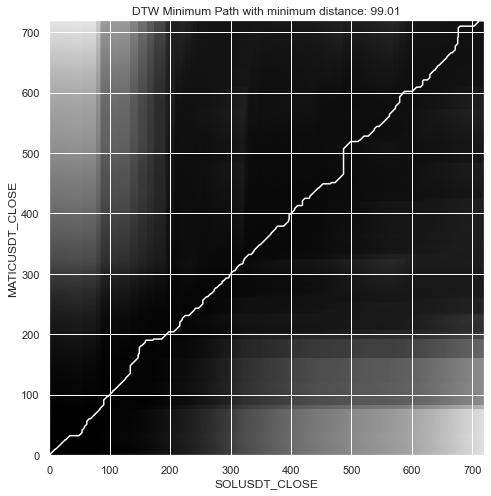

In [168]:
from dtw import dtw, accelerated_dtw

d1 = df_close['SOLUSDT_CLOSE_Norm'].interpolate().values
d2 = df_close['MATICUSDT_CLOSE_Norm'].interpolate().values

manhattan_distance = lambda d1, d2: np.abs(d1 - d2)

d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1, d2, dist=manhattan_distance)

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('SOLUSDT_CLOSE')
plt.ylabel('MATICUSDT_CLOSE')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

---
**Formatter**

In [190]:
from dtw import dtw,accelerated_dtw

def plot_dtw_coin(coin1, coin2, df_close):
    d1 = df_close[coin1].interpolate().values
    d2 = df_close[coin2].interpolate().values

    d1 = (d1-d1.mean())/d1.std()
    d2 = (d2-d2.mean())/d2.std()
 
    manhattan_distance = lambda d1, d2: np.abs(d1 - d2)

    d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1, d2, dist=manhattan_distance)
    
    coin2_min = pd.DataFrame({"c1":path[0], "c2":path[1]}).groupby("c1")["c2"].max().values
    
    return pd.DataFrame({"dtw":coin2_min}, index=df_close.index)

In [191]:
from itertools import combinations

for combo in combinations(df_close.columns.tolist(), 2):  # 2 for pairs, 3 for triplets, etc
    df_dtw = plot_dtw_coin(combo[0], combo[1], df_close)
    display(df_dtw.tail(25))

,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,690
2021-11-18 23:36:00,690
2021-11-18 23:37:00,690
2021-11-18 23:38:00,690
2021-11-18 23:39:00,690
...,...
2021-11-18 23:55:00,719
2021-11-18 23:56:00,719
2021-11-18 23:57:00,719


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,690
2021-11-18 23:36:00,690
2021-11-18 23:37:00,690
2021-11-18 23:38:00,690
2021-11-18 23:39:00,690
...,...
2021-11-18 23:55:00,717
2021-11-18 23:56:00,717
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,693
2021-11-18 23:36:00,698
2021-11-18 23:37:00,699
2021-11-18 23:38:00,699
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,714
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,679
2021-11-18 23:36:00,679
2021-11-18 23:37:00,680
2021-11-18 23:38:00,681
2021-11-18 23:39:00,691
...,...
2021-11-18 23:55:00,705
2021-11-18 23:56:00,706
2021-11-18 23:57:00,707


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,691
2021-11-18 23:36:00,691
2021-11-18 23:37:00,691
2021-11-18 23:38:00,691
2021-11-18 23:39:00,691
...,...
2021-11-18 23:55:00,717
2021-11-18 23:56:00,718
2021-11-18 23:57:00,718


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,638
2021-11-18 23:36:00,638
2021-11-18 23:37:00,638
2021-11-18 23:38:00,638
2021-11-18 23:39:00,638
...,...
2021-11-18 23:55:00,718
2021-11-18 23:56:00,718
2021-11-18 23:57:00,718


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,693
2021-11-18 23:36:00,697
2021-11-18 23:37:00,698
2021-11-18 23:38:00,699
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,717
2021-11-18 23:56:00,718
2021-11-18 23:57:00,718


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,697
2021-11-18 23:37:00,698
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,716
2021-11-18 23:56:00,717
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,713
2021-11-18 23:36:00,713
2021-11-18 23:37:00,713
2021-11-18 23:38:00,713
2021-11-18 23:39:00,713
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,690
2021-11-18 23:36:00,690
2021-11-18 23:37:00,690
2021-11-18 23:38:00,690
2021-11-18 23:39:00,690
...,...
2021-11-18 23:55:00,719
2021-11-18 23:56:00,719
2021-11-18 23:57:00,719


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,690
2021-11-18 23:36:00,690
2021-11-18 23:37:00,690
2021-11-18 23:38:00,690
2021-11-18 23:39:00,690
...,...
2021-11-18 23:55:00,717
2021-11-18 23:56:00,717
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,693
2021-11-18 23:36:00,698
2021-11-18 23:37:00,699
2021-11-18 23:38:00,699
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,714
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,713
2021-11-18 23:36:00,713
2021-11-18 23:37:00,713
2021-11-18 23:38:00,713
2021-11-18 23:39:00,713
...,...
2021-11-18 23:55:00,714
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,565
2021-11-18 23:36:00,566
2021-11-18 23:37:00,566
2021-11-18 23:38:00,567
2021-11-18 23:39:00,567
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,561
2021-11-18 23:36:00,562
2021-11-18 23:37:00,563
2021-11-18 23:38:00,564
2021-11-18 23:39:00,568
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,634
2021-11-18 23:36:00,634
2021-11-18 23:37:00,634
2021-11-18 23:38:00,634
2021-11-18 23:39:00,635
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,711
2021-11-18 23:36:00,712
2021-11-18 23:37:00,712
2021-11-18 23:38:00,712
2021-11-18 23:39:00,712
...,...
2021-11-18 23:55:00,717
2021-11-18 23:56:00,718
2021-11-18 23:57:00,718


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,538
2021-11-18 23:36:00,539
2021-11-18 23:37:00,540
2021-11-18 23:38:00,541
2021-11-18 23:39:00,562
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,713
2021-11-18 23:36:00,713
2021-11-18 23:37:00,713
2021-11-18 23:38:00,713
2021-11-18 23:39:00,713
...,...
2021-11-18 23:55:00,714
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,565
2021-11-18 23:36:00,566
2021-11-18 23:37:00,566
2021-11-18 23:38:00,567
2021-11-18 23:39:00,567
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,561
2021-11-18 23:36:00,562
2021-11-18 23:37:00,563
2021-11-18 23:38:00,564
2021-11-18 23:39:00,568
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,634
2021-11-18 23:36:00,634
2021-11-18 23:37:00,634
2021-11-18 23:38:00,634
2021-11-18 23:39:00,635
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,677
2021-11-18 23:36:00,677
2021-11-18 23:37:00,677
2021-11-18 23:38:00,679
2021-11-18 23:39:00,694
...,...
2021-11-18 23:55:00,706
2021-11-18 23:56:00,707
2021-11-18 23:57:00,708


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,696
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,687
2021-11-18 23:36:00,687
2021-11-18 23:37:00,688
2021-11-18 23:38:00,689
2021-11-18 23:39:00,690
...,...
2021-11-18 23:55:00,717
2021-11-18 23:56:00,717
2021-11-18 23:57:00,717


,dtw
_OPEN_TIMESTAMP,
2021-11-18 23:35:00,695
2021-11-18 23:36:00,696
2021-11-18 23:37:00,697
2021-11-18 23:38:00,698
2021-11-18 23:39:00,699
...,...
2021-11-18 23:55:00,715
2021-11-18 23:56:00,716
2021-11-18 23:57:00,717


KeyboardInterrupt: 

In [198]:
import mitosheet
mitosheet.sheet(df_dtw.reset_index(), view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-21308376-e3e8-460e-8b84-ac3f51c538e3", "code": {"imports…

In [ ]:
from mitosheet import *; register_analysis('UUID-21308376-e3e8-460e-8b84-ac3f51c538e3')

# Changed dtw from int32 to float
df_dtw.reset_index(['dtw'] = df_dtw.reset_index(['dtw'].astype('float')


## RSI and Bollinger Bands

https://www.ta-lib.org/function.html  
https://towardsdatascience.com/trading-strategy-technical-analysis-with-python-ta-lib-3ce9d6ce5614  
https://github.com/mrjbq7/ta-lib  
https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html  
https://awesomeopensource.com/project/mrjbq7/ta-lib

https://www.investopedia.com/terms/r/rsi.asp

The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The basic idea behind the RSI is to measure how quickly traders are bidding the price of the security up or down.  The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. Traditional interpretation and usage of the RSI are that values of 70 or above indicate that a security is becoming overbought or overvalued and may be primed for a trend reversal or corrective pullback in price. An RSI reading of 30 or below indicates an oversold or undervalued condition.

The RSI will rise as the number and size of positive closes increase, and it will fall as the number and size of losses increase.

Many investors will apply a horizontal trendline between 30% and 70% levels when a strong trend is in place to better identify extremes. Modifying overbought or oversold levels when the price of a stock or asset is in a long-term horizontal channel is usually unnecessary. An oversold reading on the RSI in an uptrend is likely much higher than 30% and that an overbought reading on the RSI during a downtrend is much lower than the 70% level. ***Maybe adjusting the 30 & 70% standards based on Ian's "states" analysis??***

https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends/

One of the more common calculations uses a 20-day simple moving average (SMA) for the middle band.
The upper band is calculated by taking the middle band and adding twice the daily standard deviation to that amount.
The lower band is calculated by taking the middle band minus two times the daily standard deviation.

When the price of the asset breaks below the lower band of the Bollinger Bands®, prices have perhaps fallen too much and are due to bounce. On the other hand, when price breaks above the upper band, the market is perhaps overbought and due for a pullback.

Using the bands as overbought/oversold indicators relies on the concept of mean reversion of the price. Mean reversion assumes that, if the price deviates substantially from the mean or average, it eventually reverts back to the mean price.

During a strong trend, for example, the trader runs the risk of placing trades on the wrong side of the move because the indicator can flash overbought or oversold signals too soon. To help remedy this, a trader can look at the overall direction of price and then ***only take trade signals that align the trader with the trend.***

***Perhaps a more useful way to trade with Bollinger Bands® is to use them to gauge trends.***

Whenever price holds between the upper Bollinger Bands® +1 SD and +2 SD away from mean, the trend is up; therefore, we can define that channel as the "buy zone." Conversely, if price channels within Bollinger Bands® –1 SD and –2 SD, it is in the "sell zone." Finally, if price meanders between +1 SD band and –1 SD band, it is essentially in a neutral state, and we can say that it's in uncharted territory.

https://stock-analysis-engine.readthedocs.io/en/latest/talib.html

BBANDS functions
Parameters:	
close – close prices
timeperiod – number of values (default is 5)
nbdevup – float - standard deviation to set the upper band (default is 2)
nbdevdn – float - standard deviation to set the lower band (default is 2)
matype – moving average type (default is 0 simple moving average)
verbose – show logs

In [199]:
# RSI
# up, mid, low of bollinger bands ... 2 standard deviations

price = df_pivot_filtered['BTCUSDT_CLOSE']
close = df_pivot_filtered['BTCUSDT_CLOSE'].values
up_2, mid_2, low_2 = BBANDS(df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=MA_Type.T3)
rsi = RSI(close, timeperiod=14)
print("RSI (first 10 elements)\n", rsi[14:24])

RSI (first 10 elements)
 [27.85862786 35.51107934 32.9540468  29.96356231 29.32442541 33.09243707
 30.76802261 32.99804712 36.2163312  38.55063244]


In [200]:
# Creating dataframe for low Bollinger Band

df_low_2 = pd.DataFrame(low_2)
df_low_2.rename(columns = {0:'LOW_2'}, inplace = True)
df_low_2.reset_index(drop=True, inplace=True)
df_low_2.tail()

,LOW_2
4315,56512.664999
4316,56525.117875
4317,56526.114953
4318,56521.892062
4319,56529.262958


In [212]:
# Creating dataframe for middle Bollinger Band

df_mid = pd.DataFrame(mid_2)
df_mid.rename(columns = {0:'MID'}, inplace = True)
df_mid.reset_index(drop=True, inplace=True)
df_mid.tail()

,MID
4315,56733.302689
4316,56738.872758
4317,56745.063258
4318,56752.081202
4319,56759.829564


In [205]:
# Creating dataframe for upper Bollinger Band

df_up_2 = pd.DataFrame(up_2)
df_up_2.rename(columns = {0:'UP_2'}, inplace = True)
df_up_2.reset_index(drop=True, inplace=True)
df_up_2.tail()

,UP_2
4315,56953.940378
4316,56952.627641
4317,56964.011562
4318,56982.270342
4319,56990.396170


In [206]:
# Creating dataframe for RSI

df_rsi = pd.DataFrame(rsi)
df_rsi.rename(columns = {0:'RSI'}, inplace = True)
df_rsi.reset_index(drop=True, inplace=True)
df_rsi

,RSI
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,53.919075
4316,54.880426
4317,55.452343
4318,58.254138


In [207]:
# Reseting index to match prior dataframes.

df_pivot_filtered.reset_index(drop=True, inplace=True)

In [208]:
# up, mid, low of bollinger bands ... 1 standard deviation

price = df_pivot_filtered['BTCUSDT_CLOSE']
close = df_pivot_filtered['BTCUSDT_CLOSE'].values
up_1, mid_1, low_1 = BBANDS(df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=20, nbdevup=1, nbdevdn=1, matype=MA_Type.T3)

In [209]:
# Creating dataframe for low Bollinger Band

df_low_1 = pd.DataFrame(low_1)
df_low_1.rename(columns = {0:'LOW_1'}, inplace = True)
df_low_1.reset_index(drop=True, inplace=True)
df_low_1.tail()

,LOW_1
4315,56622.983844
4316,56631.995316
4317,56635.589105
4318,56636.986632
4319,56644.546261


In [210]:
# Creating dataframe for upper Bollinger Band

df_up_1 = pd.DataFrame(up_1)
df_up_1.rename(columns = {0:'UP_1'}, inplace = True)
df_up_1.reset_index(drop=True, inplace=True)
df_up_1.tail()

,UP_1
4315,56843.621533
4316,56845.750199
4317,56854.537410
4318,56867.175772
4319,56875.112867


In [213]:
# Bringing together the RSI and BB dataframes.

df_rsi_bb = pd.concat([df_pivot_filtered['_OPEN_TIMESTAMP'], df_pivot_filtered['BTCUSDT_CLOSE'], df_rsi['RSI'], df_low_2['LOW_2'], df_mid['MID'], df_up_2['UP_2'], df_low_1['LOW_1'], df_up_1['UP_1']], axis=1)
df_rsi_bb

,_OPEN_TIMESTAMP,BTCUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1
0,2021-11-16 00:00:00,63432.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-11-16 00:01:00,63340.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-11-16 00:02:00,63228.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-11-16 00:03:00,63148.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-11-16 00:04:00,63091.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4315,2021-11-18 23:55:00,56845.0,53.919075,56512.664999,56733.302689,56953.940378,56622.983844,56843.621533
4316,2021-11-18 23:56:00,56866.0,54.880426,56525.117875,56738.872758,56952.627641,56631.995316,56845.750199
4317,2021-11-18 23:57:00,56878.0,55.452343,56526.114953,56745.063258,56964.011562,56635.589105,56854.537410
4318,2021-11-18 23:58:00,56937.0,58.254138,56521.892062,56752.081202,56982.270342,56636.986632,56867.175772


In [ ]:
# def bbp(price):
#     up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
#     bbp = (price['AdjClose'] - low) / (up - low)
#     return bbp

In [214]:
# Calculating how far the price is from the lower band as a percent of how far the upper band is from the lower.

df_rsi_bb['BBP_2'] = (df_rsi_bb['BTCUSDT_CLOSE'] - df_rsi_bb['LOW_2']) / (df_rsi_bb['UP_2'] - df_rsi_bb['LOW_2'])
df_rsi_bb['BBP_1'] = (df_rsi_bb['BTCUSDT_CLOSE'] - df_rsi_bb['LOW_1']) / (df_rsi_bb['UP_1'] - df_rsi_bb['LOW_1'])

In [215]:
# Just having a look.

df_rsi_bb.tail()

,_OPEN_TIMESTAMP,BTCUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,56845.0,53.919075,56512.664999,56733.302689,56953.940378,56622.983844,56843.621533,0.753124,1.006248
4316,2021-11-18 23:56:00,56866.0,54.880426,56525.117875,56738.872758,56952.627641,56631.995316,56845.750199,0.797367,1.094734
4317,2021-11-18 23:57:00,56878.0,55.452343,56526.114953,56745.063258,56964.011562,56635.589105,56854.537410,0.803580,1.107160
4318,2021-11-18 23:58:00,56937.0,58.254138,56521.892062,56752.081202,56982.270342,56636.986632,56867.175772,0.901667,1.303334
4319,2021-11-18 23:59:00,56892.0,55.392544,56529.262958,56759.829564,56990.396170,56644.546261,56875.112867,0.786621,1.073242


---
**Formatter**

In [239]:
def def_rsi_bb(coin, df_close):

    # RSI
    # up, mid, low of bollinger bands ... 2 standard deviations

    price = df_pivot_filtered[coin]
    close = df_pivot_filtered[coin].values
    up_2, mid_2, low_2 = BBANDS(df_pivot_filtered[coin], timeperiod=20, nbdevup=2, nbdevdn=2, matype=MA_Type.T3)
    rsi = RSI(close, timeperiod=14)
    #print("RSI (first 10 elements)\n", rsi[14:24])

    # Creating dataframe for low Bollinger Band

    df_low_2 = pd.DataFrame(low_2)
    df_low_2.rename(columns = {0:'LOW_2'}, inplace = True)
    df_low_2.reset_index(drop=True, inplace=True)
    #df_low_2.tail()

    # Creating dataframe for middle Bollinger Band

    df_mid = pd.DataFrame(mid_2)
    df_mid.rename(columns = {0:'MID'}, inplace = True)
    df_mid.reset_index(drop=True, inplace=True)
    #df_mid.tail()

    # Creating dataframe for upper Bollinger Band

    df_up_2 = pd.DataFrame(up_2)
    df_up_2.rename(columns = {0:'UP_2'}, inplace = True)
    df_up_2.reset_index(drop=True, inplace=True)
    #df_up_2.tail()

    # Creating dataframe for RSI

    df_rsi = pd.DataFrame(rsi)
    df_rsi.rename(columns = {0:'RSI'}, inplace = True)
    df_rsi.reset_index(drop=True, inplace=True)
    #df_rsi

    # Reseting index to match prior dataframes.

    df_pivot_filtered.reset_index(drop=True, inplace=True)

    # up, mid, low of bollinger bands ... 1 standard deviation

    price = df_pivot_filtered[coin]
    close = df_pivot_filtered[coin].values
    up_1, mid_1, low_1 = BBANDS(df_pivot_filtered[coin], timeperiod=20, nbdevup=1, nbdevdn=1, matype=MA_Type.T3)

    # Creating dataframe for low Bollinger Band

    df_low_1 = pd.DataFrame(low_1)
    df_low_1.rename(columns = {0:'LOW_1'}, inplace = True)
    df_low_1.reset_index(drop=True, inplace=True)
    #df_low_1.tail()

    # Creating dataframe for upper Bollinger Band

    df_up_1 = pd.DataFrame(up_1)
    df_up_1.rename(columns = {0:'UP_1'}, inplace = True)
    df_up_1.reset_index(drop=True, inplace=True)
    #df_up_1.tail()

    # Bringing together the RSI and BB dataframes.

    df_rsi_bb = pd.concat([df_pivot_filtered['_OPEN_TIMESTAMP'], df_pivot_filtered[coin],  df_rsi['RSI'], df_low_2['LOW_2'], df_mid['MID'], df_up_2['UP_2'], df_low_1['LOW_1'], df_up_1['UP_1']], axis=1)
    #df_rsi_bb

    # Calculating how far the price is from the lower band as a percent of how far the upper band is from the lower.

    df_rsi_bb['BBP_2'] = (df_rsi_bb[coin] - df_rsi_bb['LOW_2']) / (df_rsi_bb['UP_2'] - df_rsi_bb['LOW_2'])
    df_rsi_bb['BBP_1'] = (df_rsi_bb[coin] - df_rsi_bb['LOW_1']) / (df_rsi_bb['UP_1'] - df_rsi_bb['LOW_1'])

    # Just having a look.

    df_rsi_bb.tail()
    return df_rsi_bb

In [279]:
for coin in df_pivot_filtered.loc[:,df_pivot_filtered.columns.str.endswith('CLOSE')]:
    df_def_rsi_bb = def_rsi_bb(coin, df_pivot_filtered.loc[:,df_pivot_filtered.columns.str.endswith('CLOSE')])
    display(df_def_rsi_bb.tail())

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,99.08,60.078727,96.673870,97.980117,99.286363,97.326993,98.633240,0.921009,1.342018
4316,2021-11-18 23:56:00,99.39,62.832274,96.678863,98.035534,99.392204,97.357199,98.713869,0.999188,1.498375
4317,2021-11-18 23:57:00,99.70,65.402204,96.615980,98.099410,99.582839,97.357695,98.841125,1.039490,1.578980
4318,2021-11-18 23:58:00,100.14,68.709296,96.511141,98.173504,99.835867,97.342322,99.004686,1.091476,1.682952
4319,2021-11-18 23:59:00,100.63,71.927456,96.348800,98.260066,100.171332,97.304433,99.215699,1.119991,1.739981


,_OPEN_TIMESTAMP,BATUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,0.9736,52.576075,0.966343,0.971526,0.976709,0.968935,0.974118,0.700064,0.900128
4316,2021-11-18 23:56:00,0.9744,54.243257,0.966436,0.971542,0.976648,0.968989,0.974095,0.779869,1.059738
4317,2021-11-18 23:57:00,0.9761,57.650313,0.966174,0.971585,0.976996,0.968880,0.974290,0.917211,1.334423
4318,2021-11-18 23:58:00,0.9781,61.301116,0.965674,0.971668,0.977661,0.968671,0.974664,1.036604,1.573207
4319,2021-11-18 23:59:00,0.9781,61.301116,0.965382,0.971795,0.978209,0.968589,0.975002,0.991512,1.483025


,_OPEN_TIMESTAMP,BTCUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,56845.0,53.919075,56512.664999,56733.302689,56953.940378,56622.983844,56843.621533,0.753124,1.006248
4316,2021-11-18 23:56:00,56866.0,54.880426,56525.117875,56738.872758,56952.627641,56631.995316,56845.750199,0.797367,1.094734
4317,2021-11-18 23:57:00,56878.0,55.452343,56526.114953,56745.063258,56964.011562,56635.589105,56854.537410,0.803580,1.107160
4318,2021-11-18 23:58:00,56937.0,58.254138,56521.892062,56752.081202,56982.270342,56636.986632,56867.175772,0.901667,1.303334
4319,2021-11-18 23:59:00,56892.0,55.392544,56529.262958,56759.829564,56990.396170,56644.546261,56875.112867,0.786621,1.073242


,_OPEN_TIMESTAMP,CHZUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,0.4293,52.305804,0.426055,0.428527,0.430998,0.427291,0.429763,0.656426,0.812851
4316,2021-11-18 23:56:00,0.4296,53.642280,0.426189,0.428548,0.430907,0.427368,0.429728,0.722941,0.945883
4317,2021-11-18 23:57:00,0.4300,55.435400,0.426164,0.428578,0.430991,0.427371,0.429785,0.794641,1.089283
4318,2021-11-18 23:58:00,0.4313,60.749185,0.426001,0.428622,0.431242,0.427311,0.429932,1.011133,1.522266
4319,2021-11-18 23:59:00,0.4298,52.909790,0.426124,0.428677,0.431229,0.427401,0.429953,0.720058,0.940116


,_OPEN_TIMESTAMP,DOTUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,38.88,50.920013,38.633418,38.878161,39.122904,38.755790,39.000533,0.503757,0.507513
4316,2021-11-18 23:56:00,38.97,54.558154,38.632664,38.877227,39.121790,38.754945,38.999508,0.689672,0.879343
4317,2021-11-18 23:57:00,39.00,55.736002,38.626280,38.877111,39.127941,38.751695,39.002526,0.744965,0.989929
4318,2021-11-18 23:58:00,39.06,58.076485,38.616756,38.878244,39.139732,38.747500,39.008988,0.847542,1.195085
4319,2021-11-18 23:59:00,39.03,56.468738,38.626227,38.880728,39.135230,38.753477,39.007979,0.793263,1.086526


,_OPEN_TIMESTAMP,ENJUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,3.00,55.954594,2.940802,2.968731,2.996659,2.954766,2.982695,1.059812,1.619625
4316,2021-11-18 23:56:00,3.02,62.051366,2.934879,2.968864,3.002849,2.951871,2.985856,1.252328,2.004655
4317,2021-11-18 23:57:00,3.02,62.051366,2.930683,2.969400,3.008117,2.950042,2.988758,1.153461,1.806922
4318,2021-11-18 23:58:00,3.03,64.871070,2.926168,2.970384,3.014599,2.948276,2.992491,1.174159,1.848319
4319,2021-11-18 23:59:00,3.04,67.473780,2.921063,2.971857,3.022650,2.946460,2.997254,1.170785,1.841569


,_OPEN_TIMESTAMP,ETHUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,3988.0,53.514894,3959.037098,3981.213437,4003.389775,3970.125267,3992.301606,0.653014,0.806027
4316,2021-11-18 23:56:00,3992.0,55.730190,3959.864589,3981.640493,4003.416397,3970.752541,3992.528445,0.737866,0.975733
4317,2021-11-18 23:57:00,3994.0,56.837773,3959.887223,3982.117607,4004.347992,3971.002415,3993.232799,0.767256,1.034511
4318,2021-11-18 23:58:00,4001.0,60.557304,3959.540321,3982.677088,4005.813855,3971.108704,3994.245472,0.895970,1.291939
4319,2021-11-18 23:59:00,3997.0,57.507610,3960.420434,3983.319124,4006.217814,3971.869779,3994.768469,0.798726,1.097452


,_OPEN_TIMESTAMP,FTMUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,1.84,56.800073,1.814004,1.831296,1.848587,1.822650,1.839941,0.751695,1.003389
4316,2021-11-18 23:56:00,1.84,56.800073,1.814299,1.831357,1.848416,1.822828,1.839887,0.753319,1.006637
4317,2021-11-18 23:57:00,1.85,63.295596,1.812701,1.831542,1.850384,1.822122,1.840963,0.989816,1.479632
4318,2021-11-18 23:58:00,1.85,63.295596,1.811769,1.831869,1.851969,1.821819,1.841919,0.951025,1.402050
4319,2021-11-18 23:59:00,1.85,63.295596,1.811105,1.832342,1.853578,1.821723,1.842960,0.915750,1.331499


,_OPEN_TIMESTAMP,GALAUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,0.2311,45.232674,0.228048,0.237368,0.246687,0.232708,0.242027,0.163729,-0.172541
4316,2021-11-18 23:56:00,0.2303,43.563510,0.228361,0.236810,0.245258,0.232586,0.241034,0.114731,-0.270539
4317,2021-11-18 23:57:00,0.2315,46.738456,0.229490,0.236254,0.243018,0.232872,0.239636,0.148602,-0.202796
4318,2021-11-18 23:58:00,0.2321,48.304429,0.230929,0.235712,0.240494,0.233320,0.238103,0.122414,-0.255172
4319,2021-11-18 23:59:00,0.2288,41.139991,0.231028,0.235180,0.239332,0.233104,0.237256,-0.268344,-1.036688


,_OPEN_TIMESTAMP,LINKUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,26.42,51.908572,26.210363,26.379608,26.548854,26.294986,26.464231,0.619329,0.738658
4316,2021-11-18 23:56:00,26.46,54.280366,26.210053,26.379109,26.548165,26.294581,26.463637,0.739243,0.978486
4317,2021-11-18 23:57:00,26.48,55.463092,26.205540,26.379353,26.553166,26.292446,26.466259,0.789527,1.079055
4318,2021-11-18 23:58:00,26.53,58.363008,26.198568,26.380623,26.562678,26.289595,26.471650,0.910253,1.320506
4319,2021-11-18 23:59:00,26.55,59.499001,26.197859,26.383126,26.568394,26.290493,26.475760,0.950359,1.400718


,_OPEN_TIMESTAMP,LRCUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,2.2114,54.158725,2.192037,2.207784,2.223531,2.199911,2.215657,0.614820,0.729640
4316,2021-11-18 23:56:00,2.2134,55.495876,2.191912,2.207608,2.223303,2.199760,2.215455,0.684527,0.869054
4317,2021-11-18 23:57:00,2.2168,57.752002,2.191095,2.207530,2.223965,2.199312,2.215748,0.782014,1.064028
4318,2021-11-18 23:58:00,2.2165,57.475136,2.190449,2.207557,2.224665,2.199003,2.216111,0.761366,1.022733
4319,2021-11-18 23:59:00,2.2129,54.122059,2.190489,2.207673,2.224856,2.199081,2.216265,0.652100,0.804199


,_OPEN_TIMESTAMP,MANAUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,3.77,49.463878,3.720080,3.756740,3.793401,3.738410,3.775070,0.680846,0.861692
4316,2021-11-18 23:56:00,3.78,52.101828,3.720456,3.757484,3.794511,3.738970,3.775997,0.804055,1.108110
4317,2021-11-18 23:57:00,3.75,44.583152,3.723844,3.758180,3.792517,3.741012,3.775348,0.380883,0.261765
4318,2021-11-18 23:58:00,3.74,42.387375,3.724392,3.758729,3.793065,3.741560,3.775897,0.227279,-0.045443
4319,2021-11-18 23:59:00,3.75,45.289226,3.724235,3.759106,3.793978,3.741671,3.776542,0.369429,0.238858


,_OPEN_TIMESTAMP,MATICUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,1.49,57.439250,1.471369,1.482092,1.492816,1.476730,1.487454,0.868694,1.237388
4316,2021-11-18 23:56:00,1.49,57.439250,1.470992,1.482127,1.493263,1.476560,1.487695,0.853495,1.206991
4317,2021-11-18 23:57:00,1.50,65.998380,1.469001,1.482268,1.495534,1.475635,1.488901,1.168309,1.836618
4318,2021-11-18 23:58:00,1.50,65.998380,1.467704,1.482536,1.497368,1.475120,1.489952,1.088711,1.677422
4319,2021-11-18 23:59:00,1.49,53.516561,1.468069,1.482902,1.497734,1.475486,1.490318,0.739280,0.978559


,_OPEN_TIMESTAMP,SOLUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,195.0,53.410678,193.450186,194.776836,196.103486,194.113511,195.440161,0.584108,0.668216
4316,2021-11-18 23:56:00,195.0,53.410678,193.465960,194.773629,196.081299,194.119794,195.427464,0.586555,0.673110
4317,2021-11-18 23:57:00,195.0,53.410678,193.464746,194.772416,196.080085,194.118581,195.426251,0.587019,0.674038
4318,2021-11-18 23:58:00,195.0,53.410678,193.465979,194.773649,196.081318,194.119814,195.427483,0.586548,0.673095
4319,2021-11-18 23:59:00,195.0,53.410678,193.611298,194.777488,195.943678,194.194393,195.360583,0.595401,0.690802


In [ ]:
# Just having a look at the distribution of BBP.

sns.histplot(df_rsi_bb['BBP_1'])

In [ ]:
# Just having a look at the distribution of RSI.

sns.histplot(df_rsi_bb['RSI'])

In [ ]:
# Creating rules that will display as red and green dots on the chart below.
# An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%.

max_holding = 100

holdings = pd.DataFrame(index = df_rsi_bb.index, data={'Holdings': np.array([np.nan] * df_rsi_bb.index.shape[0])})
holdings.loc[((df_rsi_bb['RSI'] < 30) & (df_rsi_bb['BBP_2'] < 0)), 'Holdings'] = max_holding
holdings.loc[((df_rsi_bb['RSI'] > 70) & (df_rsi_bb['BBP_2'] > 1)), 'Holdings'] = 0
holdings.loc[((df_rsi_bb['RSI'] < 30) & (df_rsi_bb['BBP_1'] < 0)), 'Holdings'] = max_holding
holdings.loc[((df_rsi_bb['RSI'] > 70) & (df_rsi_bb['BBP_1'] > 1)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)

In [ ]:
holdings['Holdings'].unique()

In [ ]:
holdings['Order'] = holdings.diff()
holdings.fillna(0,inplace=True)

In [ ]:
holdings.shape

In [ ]:
holdings.info()

In [ ]:
index1 = holdings.index

In [ ]:
index1

In [ ]:
index = index1.values

In [ ]:
holdings1 = holdings.copy()

In [ ]:
num = 700
holdings = holdings1.iloc[-num:]
index = index1[-num:]
df_rsi_bb = df_rsi_bb.iloc[-num:, :]

In [ ]:
df_rsi_bb.tail()

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(15, 20))
ax0.plot(index, df_rsi_bb['BTCUSDT_CLOSE'], label='Price')
ax0.set_xlabel('Date')
ax0.set_ylabel('Price')
ax0.grid()
for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        ax0.scatter(x=day, y=df_rsi_bb.loc[day, 'BTCUSDT_CLOSE'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=df_rsi_bb.loc[day, 'BTCUSDT_CLOSE'], color='red')

ax1.plot(index, df_rsi_bb['RSI'], label='RSI')
ax1.fill_between(index, y1=30, y2=70, color='#adccff', alpha=0.3)
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')
ax1.grid()

ax2.plot(index, df_rsi_bb['UP_2'], label='Up_2', color='darkgreen')
ax2.plot(index, df_rsi_bb['UP_1'], label='Up_1', color='darkgreen')
ax2.plot(index, df_rsi_bb['BTCUSDT_CLOSE'], label='Price', color='black')
ax2.plot(index, df_rsi_bb['LOW_1'], label='Low_1', color='darkred')
ax2.plot(index, df_rsi_bb['LOW_2'], label='Low_2', color='darkred')
ax2.fill_between(index, y1=df_rsi_bb['UP_1'], y2=df_rsi_bb['UP_2'], color='green', alpha=0.3)
ax2.fill_between(index, y1=df_rsi_bb['LOW_1'], y2=df_rsi_bb['LOW_2'], color='red', alpha=0.3)
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.grid()

# fig.tight_layout()
plt.show()

## Death / Golden Cross

In [248]:
# Calculate a simple moving average of the close prices

SMA_BTC_60 = pd.DataFrame(talib.SMA(df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=60))
SMA_BTC_60.rename(columns = {0:'SMA_BTC_60'}, inplace = True)
SMA_BTC_60.tail()

,SMA_BTC_60
4315,56728.766667
4316,56728.550000
4317,56728.583333
4318,56732.716667
4319,56737.366667


In [249]:
# Calculate a simple moving average of the close prices:

SMA_BTC_180 = pd.DataFrame(talib.SMA(df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=180))
SMA_BTC_180.rename(columns = {0:'SMA_BTC_180'}, inplace = True)
SMA_BTC_180.tail()

,SMA_BTC_180
4315,57280.177778
4316,57272.950000
4317,57266.100000
4318,57260.166667
4319,57254.227778


In [250]:
# Merge dataframes.

SMA_BTC = pd.concat([df_pivot_filtered['_OPEN_TIMESTAMP'],SMA_BTC_60['SMA_BTC_60'], SMA_BTC_180['SMA_BTC_180']], axis=1)
SMA_BTC.shape

(4320, 3)

In [251]:
SMA_BTC['SMA_BTC_60'].fillna("0",inplace=True)
SMA_BTC['SMA_BTC_180'].fillna("0",inplace=True)
SMA_BTC.shape

(4320, 3)

In [252]:
SMA_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   _OPEN_TIMESTAMP  4320 non-null   datetime64[ns]
 1   SMA_BTC_60       4320 non-null   object        
 2   SMA_BTC_180      4320 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 101.4+ KB


In [253]:
SMA_BTC['SMA_BTC_60'] = SMA_BTC['SMA_BTC_60'].astype(float)
SMA_BTC['SMA_BTC_180'] = SMA_BTC['SMA_BTC_180'].astype(float)
SMA_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   _OPEN_TIMESTAMP  4320 non-null   datetime64[ns]
 1   SMA_BTC_60       4320 non-null   float64       
 2   SMA_BTC_180      4320 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 101.4 KB


In [254]:
# Checking how many periods have increased momentum.

SMA_BTC["Cross_Num"] = (SMA_BTC["SMA_BTC_60"] > SMA_BTC["SMA_BTC_180"]).astype(int)
SMA_BTC.Cross_Num.sum()

1681

In [255]:
# Filtering to the most recent day.
num = 1440
SMA_BTC = SMA_BTC.iloc[-num:]
SMA_BTC.shape

(1440, 4)

In [256]:
# Just checking it out.

SMA_BTC.shape

(1440, 4)

In [257]:
# Set index as timestamp for easier access

SMA_BTC = SMA_BTC.set_index("_OPEN_TIMESTAMP")
SMA_BTC

,SMA_BTC_60,SMA_BTC_180,Cross_Num
_OPEN_TIMESTAMP,,,
2021-11-18 00:00:00,60066.633333,59981.588889,1
2021-11-18 00:01:00,60071.283333,59981.416667,1
2021-11-18 00:02:00,60073.850000,59980.611111,1
2021-11-18 00:03:00,60075.616667,59980.255556,1
2021-11-18 00:04:00,60077.133333,59980.133333,1
...,...,...,...
2021-11-18 23:55:00,56728.766667,57280.177778,0
2021-11-18 23:56:00,56728.550000,57272.950000,0
2021-11-18 23:57:00,56728.583333,57266.100000,0


In [258]:
SMA_BTC['Prior'] = SMA_BTC['Cross_Num'].shift()
SMA_BTC['Prior'].sum()

477.0

In [259]:
SMA_BTC['Signal_Buy'] = (SMA_BTC["Cross_Num"] == 1 ) & (SMA_BTC["Prior"] == 0)
print(SMA_BTC['Signal_Buy'].sum())
SMA_BTC['Signal_Sell'] = (SMA_BTC["Cross_Num"] == 0 ) & (SMA_BTC["Prior"] == 1)
print(SMA_BTC['Signal_Sell'].sum())
                     

3
4


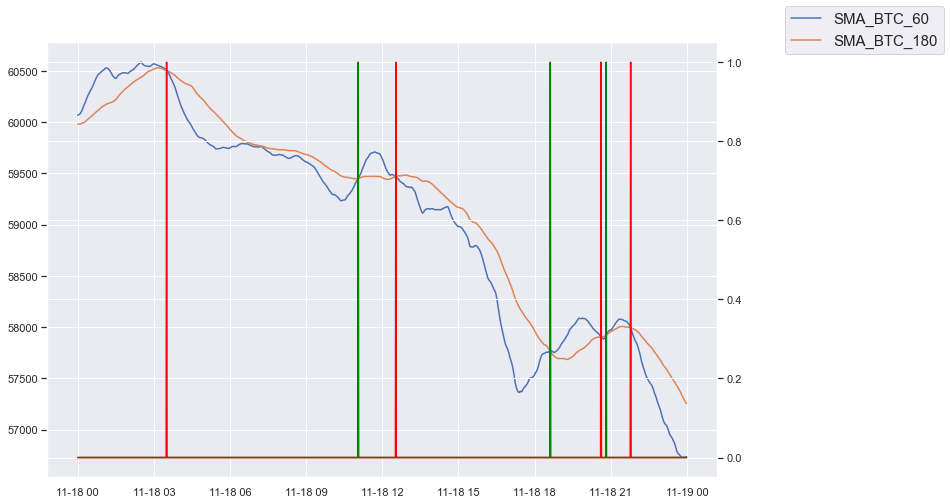

In [260]:
fig, ax = plt.subplots()
ax.plot(SMA_BTC["SMA_BTC_60"])
ax.plot(SMA_BTC["SMA_BTC_180"])

ax2=ax.twinx()
ax2.plot(SMA_BTC["Signal_Buy"], color = 'green')
ax2.plot(SMA_BTC["Signal_Sell"], color = 'red')

ax.legend(("SMA_BTC_60","SMA_BTC_180"), bbox_to_anchor=(1.35, 1.1), prop={'size': 15})
plt.show()

---
**Formatter**

In [263]:
def def_cross(coin, df_close):    
    
    # Calculate a simple moving average of the close prices

    SMA_60 = pd.DataFrame(talib.SMA(df_pivot_filtered[coin], timeperiod=60))
    SMA_60.rename(columns = {0:'SMA_60'}, inplace = True)
    #SMA_60.tail()

    # Calculate a simple moving average of the close prices:

    SMA_180 = pd.DataFrame(talib.SMA(df_pivot_filtered[coin], timeperiod=180))
    SMA_180.rename(columns = {0:'SMA_180'}, inplace = True)
    #SMA_180.tail()

    # Merge dataframes.

    SMA = pd.concat([df_pivot_filtered['_OPEN_TIMESTAMP'],SMA_60['SMA_60'], SMA_180['SMA_180']], axis=1)
    #SMA.shape

    SMA['SMA_60'].fillna("0",inplace=True)
    SMA['SMA_180'].fillna("0",inplace=True)
    #SMA.shape

    #SMA.info()

    SMA['SMA_60'] = SMA['SMA_60'].astype(float)
    SMA['SMA_180'] = SMA['SMA_180'].astype(float)
    #SMA.info()

    # Checking how many periods have increased momentum.

    SMA["Cross_Num"] = (SMA["SMA_60"] > SMA["SMA_180"]).astype(int)
    #SMA.Cross_Num.sum()

    # Filtering to the most recent day.
    num = 1440
    SMA = SMA.iloc[-num:]
    #SMA.shape

    # Just checking it out.

   # SMA.shape

    # Set index as timestamp for easier access

    SMA = SMA.set_index("_OPEN_TIMESTAMP")
    #SMA

    SMA['Prior'] = SMA['Cross_Num'].shift()
    #SMA['Prior'].sum()

    SMA['Signal_Buy'] = (SMA["Cross_Num"] == 1 ) & (SMA["Prior"] == 0)
    #print(SMA['Signal_Buy'].sum())
    SMA['Signal_Sell'] = (SMA["Cross_Num"] == 0 ) & (SMA["Prior"] == 1)
    #print(SMA['Signal_Sell'].sum())

    return SMA

In [ ]:
for coin in df_pivot_filtered.loc[:,df_pivot_filtered.columns.str.endswith('CLOSE')]:
    df_def_cross = def_cross(coin, df_pivot_filtered.loc[:,df_pivot_filtered.columns.str.endswith('CLOSE')])
    display(df_def_cross.tail())

In [416]:
import mitosheet
mitosheet.sheet(df_def_cross, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-804e892d-4156-4162-b26a-65f347eec835", "code": {"imports…

## Ta-lib Add'l TA

https://www.ta-lib.org/function.html  
https://awesomeopensource.com/project/mrjbq7/ta-lib  
https://mrjbq7.github.io/ta-lib/  
https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html

In [ ]:
print(talib.get_function_groups())

In [ ]:
print(talib.get_functions())

---
***I can't figure out or find out how MOM is helpful...***

In [ ]:
# Calculating momentum of the close prices

df_MOM = pd.DataFrame(talib.MOM(df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=5))
df_MOM.rename(columns = {0:'MOM_BTC'}, inplace=True)
df_MOM.reset_index(drop = True, inplace=True)
df_MOM

In [ ]:
plt.hist(df_MOM, bins=30)
plt.show()

In [ ]:
# Assembling low correlation coins

df_MOM_price = pd.concat([df_pivot_filtered, df_MOM], axis=1).reset_index(drop=True).drop_duplicates()
print(df_MOM_price.shape)
df_MOM_price.tail()

In [ ]:
fig, ax1 = plt.subplots(figsize=(16,8))
sns.set_theme(style="whitegrid")

ax1 = sns.lineplot(data=df_MOM_price['BTCUSDT_CLOSE'], color='black')
ax2 = ax1.twinx()
ax2 = sns.lineplot(data=df_MOM_price['MOM_BTC'], color='lightgray')
plt.show()

---

***BETA***

In [272]:
# Calculating mean price across basket of coins.

df_pivot_filtered['avg_price'] = df_pivot_filtered[['AVAXUSDT_CLOSE','BATUSDT_CLOSE','BTCUSDT_CLOSE','CHZUSDT_CLOSE',
                                                    'DOTUSDT_CLOSE','ENJUSDT_CLOSE','ETHUSDT_CLOSE','FTMUSDT_CLOSE',
                                                   'GALAUSDT_CLOSE','LINKUSDT_CLOSE','LRCUSDT_CLOSE','MANAUSDT_CLOSE',
                                                   'MATICUSDT_CLOSE','SOLUSDT_CLOSE']].mean(axis=1)

In [273]:
# Calculating Beta against avg of all coins.

df_beta = pd.DataFrame(talib.BETA(df_pivot_filtered['avg_price'], df_pivot_filtered['ETHUSDT_CLOSE'], timeperiod=60))
df_beta.rename(columns = {0:'beta_avg_eth'}, inplace=True)
df_beta.reset_index(drop = True, inplace=True)
df_beta

,beta_avg_eth
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,1.178401
4316,1.181253
4317,1.180147
4318,1.219809


---
**Formatter**

In [275]:
def def_beta(coin, df_close):

    # Calculating mean price across basket of coins.

    df_pivot_filtered['avg_price'] = df_pivot_filtered[['AVAXUSDT_CLOSE','BATUSDT_CLOSE','BTCUSDT_CLOSE','CHZUSDT_CLOSE',
                                                        'DOTUSDT_CLOSE','ENJUSDT_CLOSE','ETHUSDT_CLOSE','FTMUSDT_CLOSE',
                                                       'GALAUSDT_CLOSE','LINKUSDT_CLOSE','LRCUSDT_CLOSE','MANAUSDT_CLOSE',
                                                       'MATICUSDT_CLOSE','SOLUSDT_CLOSE']].mean(axis=1)
        
    # Calculating Beta against avg of all coins.

    df_beta = pd.DataFrame(talib.BETA(df_pivot_filtered['avg_price'], df_pivot_filtered[coin], timeperiod=60))
    df_beta.rename(columns = {0:'beta_avg'}, inplace=True)
    df_beta.reset_index(drop = True, inplace=True)
    #df_beta
    return df_beta

In [277]:
for coin in df_pivot_filtered.loc[:,df_pivot_filtered.columns.str.endswith('CLOSE')]:
    df_def_beta = def_beta(coin, df_pivot_filtered.loc[:,df_pivot_filtered.columns.str.endswith('CLOSE')])
    display(df_def_beta.tail())

,beta_avg
4315,1.918816
4316,1.965518
4317,1.971512
4318,1.900269
4319,1.913018


,beta_avg
4315,1.063014
4316,1.043601
4317,1.046553
4318,1.061558
4319,1.057341


,beta_avg
4315,0.983782
4316,0.983388
4317,0.983457
4318,0.980867
4319,0.980313


,beta_avg
4315,1.220433
4316,1.224909
4317,1.225044
4318,1.291590
4319,1.291388


,beta_avg
4315,1.634941
4316,1.627423
4317,1.627416
4318,1.642222
4319,1.645170


,beta_avg
4315,1.416310
4316,1.465472
4317,1.469705
4318,1.451128
4319,1.404346


,beta_avg
4315,1.178401
4316,1.181253
4317,1.180147
4318,1.219809
4319,1.226885


,beta_avg
4315,1.617496
4316,1.657426
4317,1.665736
4318,1.786242
4319,1.737991


,beta_avg
4315,-0.275229
4316,-0.375035
4317,-0.364016
4318,0.031334
4319,0.006333


,beta_avg
4315,1.501897
4316,1.510042
4317,1.510604
4318,1.554359
4319,1.550418


,beta_avg
4315,1.330149
4316,1.339000
4317,1.339739
4318,1.311777
4319,1.272020


,beta_avg
4315,1.607544
4316,1.614138
4317,1.603585
4318,1.584882
4319,1.552471


,beta_avg
4315,1.294795
4316,1.232841
4317,1.237057
4318,1.148219
4319,1.206983


,beta_avg
4315,1.389517
4316,1.422232
4317,1.421610
4318,1.391223
4319,1.403995


---

***Direction Movement Index (DX)***

https://www.investopedia.com/terms/d/dmi.asp  
Identifies in which direction the price of an asset is moving. The indicator does this by comparing prior highs and lows and drawing two lines: a positive directional movement line (+DI) and a negative directional movement line (-DI). An optional third line, called the average directional index (ADX), can also be used to gauge the strength of the uptrend or downtrend.

When +DI is above -DI, there is more upward pressure than downward pressure in the price. Conversely, if -DI is above +DI, then there is more downward pressure on the price. This indicator may help traders assess the trend direction. Crossovers between the lines are also sometimes used as trade signals to buy or sell.

***KEY TAKEAWAYS***  
The directional movement index (DMI) is a technical indicator that measures both the strength and direction of a price movement and is intended to reduce false signals.  
The DMI utilizes two standard indicators, one negative (-DM) and one positive (+DN), in conjunction with a third, the average directional index (ADX), which is non-directional but shows momentum.  
The larger the spread between the two primary lines, the stronger the price trend. If +DI is way above -DI the price trend is strongly up. If -DI is way above +DI then the price trend is strongly down.  ADX measures the strength of the trend, either up or down; a reading above 25 indicates a strong trend.

Crossovers are the main trade signals. A long trade is taken when the +DI crosses above the -DI and an uptrend could be underway. Meanwhile, a sell signal occurs when the +DI instead crosses below the -DI

In [280]:
# Calculating Directional Movement Index (DX)

df_dx = pd.DataFrame(talib.DX(df_pivot_filtered['BTCUSDT_HIGH'], df_pivot_filtered['BTCUSDT_LOW'], df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=60))
df_dx.rename(columns = {0:'dx_btc'}, inplace=True)
df_dx.reset_index(drop = True, inplace=True)
df_dx

,dx_btc
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,3.981594
4316,3.270230
4317,2.259390
4318,2.259390


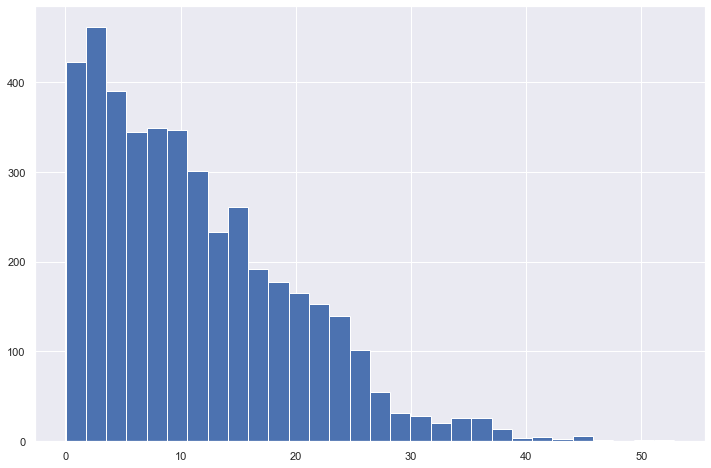

In [282]:
plt.hist(df_dx, bins=30)
plt.show()

In [283]:
# Calculating Average Directional Movement Index (ADX)

df_adx = pd.DataFrame(talib.ADX(df_pivot_filtered['BTCUSDT_HIGH'], df_pivot_filtered['BTCUSDT_LOW'], df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=60))
df_adx.rename(columns = {0:'adx_btc'}, inplace=True)
df_adx.reset_index(drop = True, inplace=True)
df_adx

,adx_btc
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,12.124315
4316,11.976747
4317,11.814791
4318,11.655534


In [284]:
# Calculating Minus Directional Indicator (-DI)

df_adx_neg = pd.DataFrame(talib.MINUS_DM(df_pivot_filtered['BTCUSDT_HIGH'], df_pivot_filtered['BTCUSDT_LOW'], timeperiod=60))
df_adx_neg.rename(columns = {0:'adx_neg_btc'}, inplace=True)
df_adx_neg.reset_index(drop = True, inplace=True)
df_adx_neg

,adx_neg_btc
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,1900.465062
4316,1868.790644
4317,1837.644134
4318,1807.016731


In [285]:
# Calculating Positive Directional Indicator (+DI)

df_dx_pos = pd.DataFrame(talib.PLUS_DM(df_pivot_filtered['BTCUSDT_HIGH'], df_pivot_filtered['BTCUSDT_LOW'], timeperiod=60))
df_dx_pos.rename(columns = {0:'dx_btc_pos'}, inplace=True)
df_dx_pos.reset_index(drop = True, inplace=True)
df_dx_pos

,dx_btc_pos
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,1754.922375
4316,1750.433669
4317,1756.439775
4318,1727.165778


---
**Formatter**

In [410]:
df_coins = pd.DataFrame(df_close.columns.str.split('_').str[0].unique())
df_coins.rename(columns = {0:'coins'}, inplace=True)
df_coins

,coins
0,AVAXUSDT
1,BATUSDT
2,BTCUSDT
3,CHZUSDT
4,DOTUSDT
...,...
9,LINKUSDT
10,LRCUSDT
11,MANAUSDT
12,MATICUSDT


In [411]:
def def_direct_mov(coins, df_pivot_filtered):

    # Calculating Directional Movement Index (DX)

    df_dx = pd.DataFrame(talib.DX(df_pivot_filtered[coins+'_HIGH'], df_pivot_filtered[coins+'_LOW'], df_pivot_filtered[coins+'_CLOSE'], timeperiod=60))
    df_dx.rename(columns = {0:'dx'}, inplace=True)
    df_dx.reset_index(drop = True, inplace=True)
    #df_dx

    # Calculating Average Directional Movement Index (ADX)

    df_adx = pd.DataFrame(talib.ADX(df_pivot_filtered[coins+'_HIGH'], df_pivot_filtered[coins+'_LOW'], df_pivot_filtered[coins+'_CLOSE'], timeperiod=60))
    df_adx.rename(columns = {0:'adx'}, inplace=True)
    df_adx.reset_index(drop = True, inplace=True)
    #df_adx

    # Calculating Minus Directional Indicator (-DI)

    df_adx_neg = pd.DataFrame(talib.MINUS_DM(df_pivot_filtered[coins+'_HIGH'], df_pivot_filtered[coins+'_LOW'], timeperiod=60))
    df_adx_neg.rename(columns = {0:'adx_neg'}, inplace=True)
    df_adx_neg.reset_index(drop = True, inplace=True)
    #df_adx_neg

    # Calculating Positive Directional Indicator (+DI)

    df_dx_pos = pd.DataFrame(talib.PLUS_DM(df_pivot_filtered[coins+'_HIGH'], df_pivot_filtered[coins+'_LOW'], timeperiod=60))
    df_dx_pos.rename(columns = {0:'dx_pos'}, inplace=True)
    df_dx_pos.reset_index(drop = True, inplace=True)
    #df_dx_pos
    
    return pd.DataFrame({"DX":np.squeeze(df_dx.values), "ADX":np.squeeze(df_adx.values), "MDI":np.squeeze(df_adx_neg.values), "PDI":np.squeeze(df_dx_pos.values)}, index=df_pivot_filtered.index) 

In [412]:
#suffixes = ("CLOSE","HIGH","LOW")

for coin in df_coins['coins']:
    df_def_direct_mov = def_direct_mov(coin, df_pivot_filtered)
    display(df_def_direct_mov.tail())

,DX,ADX,MDI,PDI
4315,5.649974,14.234440,6.459293,7.232898
4316,8.372135,14.136735,6.351638,7.512349
4317,9.696915,14.062738,6.245777,7.587144
4318,12.898614,14.043336,6.141681,7.960691
4319,17.140952,14.094963,6.039319,8.538013


,DX,ADX,MDI,PDI
4315,2.847461,11.290332,0.038763,0.036617
4316,0.378132,11.108462,0.038117,0.038406
4317,2.325185,10.962074,0.037482,0.039266
4318,2.711918,10.824571,0.036857,0.038912
4319,4.127369,10.712951,0.036243,0.039363


,DX,ADX,MDI,PDI
4315,3.981594,12.124315,1900.465062,1754.922375
4316,3.270230,11.976747,1868.790644,1750.433669
4317,2.259390,11.814791,1837.644134,1756.439775
4318,2.259390,11.655534,1807.016731,1727.165778
4319,1.027965,11.478408,1776.899786,1740.739682


,DX,ADX,MDI,PDI
4315,2.008793,11.492050,0.020475,0.019669
4316,0.231411,11.304372,0.020134,0.020041
4317,0.524001,11.124699,0.019798,0.020007
4318,1.530286,10.964792,0.019468,0.020073
4319,0.496448,10.790320,0.019544,0.019739


,DX,ADX,MDI,PDI
4315,3.257337,12.270968,1.976545,1.851841
4316,1.637436,12.093742,1.943602,1.880977
4317,0.041386,11.892869,1.911209,1.909628
4318,0.041386,11.695345,1.879355,1.877800
4319,1.030141,11.517591,1.848033,1.886504


,DX,ADX,MDI,PDI
4315,12.129875,12.406331,0.263370,0.206389
4316,8.149737,12.335388,0.258981,0.219949
4317,5.027554,12.213591,0.254664,0.230283
4318,4.807769,12.090160,0.250420,0.227445
4319,0.529037,11.897475,0.246246,0.243655


,DX,ADX,MDI,PDI
4315,1.111305,12.649184,140.028276,136.950199
4316,0.686176,12.449801,137.694471,135.817695
4317,1.299190,12.263957,135.399563,138.964067
4318,2.140706,12.095236,133.142904,138.967999
4319,4.034370,11.960889,130.923856,141.931866


,DX,ADX,MDI,PDI
4315,4.162235,18.710160,0.127363,0.117184
4316,3.602157,18.458360,0.125240,0.116531
4317,1.635639,18.177981,0.123153,0.119189
4318,1.635639,17.902276,0.121100,0.117203
4319,0.732904,17.616119,0.119082,0.117349


,DX,ADX,MDI,PDI
4315,11.884845,17.649983,0.032927,0.041809
4316,11.956727,17.555096,0.032378,0.041172
4317,13.675463,17.490435,0.031839,0.041926
4318,13.675463,17.426852,0.031308,0.041227
4319,9.989933,17.302904,0.033176,0.040540


,DX,ADX,MDI,PDI
4315,3.611308,10.634996,1.246211,1.159339
4316,2.313711,10.496308,1.225441,1.170017
4317,0.187078,10.324487,1.205017,1.200517
4318,0.652909,10.163294,1.184933,1.200508
4319,3.929415,10.059396,1.165184,1.260500


,DX,ADX,MDI,PDI
4315,0.768709,16.309561,0.111380,0.113106
4316,1.216212,16.058005,0.109524,0.112220
4317,1.756880,15.819653,0.107698,0.111550
4318,2.749262,15.601813,0.105903,0.111891
4319,5.011276,15.425304,0.104138,0.115126


,DX,ADX,MDI,PDI
4315,9.680144,10.042562,0.417075,0.343455
4316,7.594025,10.001753,0.410124,0.352231
4317,9.584107,9.994792,0.419789,0.346360
4318,10.581106,10.004564,0.421192,0.340587
4319,11.138652,10.023465,0.418872,0.334911


,DX,ADX,MDI,PDI
4315,1.643639,11.060721,0.065805,0.068004
4316,4.545446,10.952133,0.064708,0.070871
4317,5.956245,10.868868,0.063630,0.071690
4318,7.348821,10.810201,0.062569,0.072495
4319,6.546593,10.739140,0.062527,0.071287


,DX,ADX,MDI,PDI
4315,4.817609,10.216477,9.421144,10.374836
4316,5.449048,10.137020,9.264124,10.331922
4317,6.082655,10.069447,9.109722,10.289724
4318,6.082655,10.003001,8.957894,10.118228
4319,4.467595,9.910744,9.098595,9.949591


Max Facts : tax advantage for holding over a year, listed as a trader gets an advantage